### Phase Clustering

In [1]:
import numpy as np
import matplotlib.pylab as plt
import os, sys
plt.rcParams["font.family"] = "Times New Roman"
from matplotlib import rc
from matplotlib.patches import Circle
#import peakutils
from numpy import loadtxt
from scipy import signal
from sklearn.cluster import KMeans
#import peakutils as pu
#from peakutils.plot import plot as pplot
from sklearn import preprocessing
%matplotlib inline
import scipy
from scipy.cluster.hierarchy import fclusterdata, linkage, fcluster, dendrogram
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import ternary
import time
import peakutils
from dtw import dtw
from collections import Counter
from pyemd import emd
import time
label_size = 12
plt.rcParams["font.family"] = "Times New Roman"
#plt.rcParams["font.family"] = "serif"
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams.update({'font.size':label_size, 'font.weight':'bold'})
tick_size = 12
dpi = 300
params = {'axes.labelsize': label_size,'axes.titlesize':label_size, 'legend.fontsize': label_size, 'xtick.labelsize': tick_size, 'ytick.labelsize': tick_size, 'axes.labelweight':'bold'}
plt.rcParams.update(params)
% matplotlib inline

In [2]:
pts_200=loadtxt('110917A_xya123_200.txt', comments="#", delimiter=" ", unpack=False)
#pts_200[:,[3,4]] = pts_200[:,[4,3]]
#pts2_200=loadtxt('111017A_xya123_200.txt', comments="#", delimiter=" ", unpack=False)
print pts_200.shape

(1950, 205)


In [3]:
!pwd

/raid/dkj755/PhaseClustering


In [4]:
path="/home/dkj755/PhaseClustering/Achari-0119/110917A_FCM_clustering_20181110"
path = '/home/dkj755/PhaseClustering/Achari-1218'
#%%
sample_name='110917A'
#xrd_data=np.genfromtxt('Achari-1218/XRD_data_110917A.txt')
xrd_data = np.copy(pts_200)
X_Y_atomic_ratios=np.genfromtxt("Achari-0119/110917A_FCM_clustering_20181110/atomratios.txt")
xrd_xy=np.genfromtxt("Achari-0119/110917A_FCM_clustering_20181110/xrd_xy.txt")
xrd_data.shape, X_Y_atomic_ratios.shape, xrd_xy.shape

((1950, 205), (1859, 3), (1859, 2))

In [5]:
X_Y_atomic_ratios[-2,:]

array([ 30.39,   2.66,  66.95])

In [6]:
def match_xy(xrdxy,xrfxy,a123):
    """
    xrdxy and xrfxy are arrays with 2 columns.
    a123 is an array with 3 columns a=containing atomic ratios corresponding to the xrfxy array.
    
    The logic is to choose x and y from xrd data and match them with corresponsing xy in xrf data 
    and get the atomic ratios at that location.
    """
    matched_a123=np.empty((xrdxy.shape[0],3))
    del_list=list()
    for i in range(xrdxy.shape[0]): 
        x_matched_rows=np.where(xrfxy[:,0]==xrdxy[i,0])[0]
        y_matched_rows=np.where(xrfxy[:,1]==xrdxy[i,1])[0]
        matched_row=np.intersect1d(x_matched_rows,y_matched_rows)
#         matched_a123[i,:]=a123[matched_row,:]
#         print(len(matched_row))
        if matched_row.shape[0]>0:
            matched_a123[i,:]=a123[matched_row[0],:]
        else:
            del_list.append(i)
            #print("Nomatch: ", 'xrd row = ',i,' x,y= ',xrdxy[i,:])
    print("Delete these rows from xrd data ans xrd-xy data. -> ",del_list)
    return matched_a123, del_list

In [7]:
atomic_ratios, del_list = match_xy(xrd_data[:,:2], xrd_xy, X_Y_atomic_ratios)

('Delete these rows from xrd data ans xrd-xy data. -> ', [9, 36, 48, 56, 57, 82, 87, 119, 150, 157, 173, 264, 295, 305, 312, 337, 345, 346, 355, 366, 391, 433, 435, 436, 483, 509, 515, 525, 533, 556, 569, 579, 581, 608, 657, 665, 686, 765, 768, 769, 778, 794, 809, 814, 815, 866, 876, 904, 914, 921, 950, 952, 953, 966, 1000, 1001, 1002, 1011, 1012, 1015, 1019, 1065, 1070, 1073, 1077, 1100, 1101, 1113, 1148, 1150, 1159, 1164, 1184, 1197, 1239, 1248, 1256, 1257, 1258, 1290, 1295, 1307, 1315, 1316, 1321, 1340, 1343, 1344, 1345, 1346, 1364, 1389, 1391, 1393, 1403, 1408, 1437, 1438, 1441, 1442, 1456, 1459, 1481, 1483, 1488, 1499, 1504, 1505, 1528, 1539, 1545, 1548, 1550, 1556, 1571, 1572, 1580, 1589, 1612, 1613, 1614, 1641, 1654, 1655, 1671, 1673, 1682, 1690, 1695, 1696, 1699, 1702, 1704, 1733, 1734, 1735, 1736, 1751, 1752, 1770, 1771, 1772, 1773, 1774, 1785, 1789, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1828, 1835, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1845, 1848, 1849, 1866, 18

In [8]:
print atomic_ratios.shape, xrd_data.shape

(1950, 3) (1950, 205)


In [9]:
xrd_data = np.delete(xrd_data, del_list, axis=0)
atomic_ratios = np.delete(atomic_ratios, del_list, axis=0)
del_list = []
xrd_data[:,2:5] = atomic_ratios
print xrd_data.shape, pts_200.shape, atomic_ratios.shape
print pts_200[1:10, 2:5]
print pts_200[10,:5], xrd_data[10,:5]
pts_200 = xrd_data

(1729, 205) (1950, 205) (1729, 3)
[[  2.54  39.77  57.69]
 [  2.73  41.7   55.57]
 [  3.39  56.19  40.42]
 [  3.23  51.57  45.2 ]
 [  3.12  51.05  45.83]
 [  3.86  63.18  32.95]
 [  3.29  53.81  42.9 ]
 [  3.32  54.97  41.7 ]
 [  3.45  61.1   35.45]]
[-48.     8.     3.61  61.23  35.16] [-48.    10.     5.25  90.96   3.79]


In [10]:
invs = []
zpeaks = []
for i in range(pts_200.shape[0]):
    if int(np.sum(pts_200[i,2:5]))>100:
        print pts_200[i,2:5]
        invs.append(i)
    if len(np.where(pts_200[i, 5:]>0)[0])==0:
        print np.where(pts_200[i,5:]>0)[0]
        zpeaks.append(i)
print 'entries with invalid comp: ', len(invs)
print 'entries with zero peaks: ', len(zpeaks), zpeaks
pts_200 = np.delete(pts_200, invs+zpeaks, axis=0)
print pts_200.shape
pts2_200 = pts_200
# invs = []
# zpeaks = []
# for i in range(pts2_200.shape[0]):
#     if np.sum(pts2_200[i,2:5])>101:
#         invs.append(i)
#     if len(np.where(pts2_200[i, 5:]>0)[0])==0:
#         zpeaks.append(i)
# print 'entries with invalid comp: ', len(invs)
# print 'entries with zero peaks: ', len(zpeaks), zpeaks
# pts2_200 = np.delete(pts2_200, invs+zpeaks, axis=0)
# print pts2_200.shape

[]
[]
[]
[]
[]
entries with invalid comp:  0
entries with zero peaks:  5 [876, 877, 965, 1727, 1728]
(1724, 205)


In [11]:
path=r"Achari-0119/112417A_FCM_clustering_20190118"
sample_name='112417A'

In [12]:
xrd_xy=np.loadtxt(path+'/'+'xrd_xy.txt')
datas=np.loadtxt(path+'/'+'datas.txt')
atomratios=np.loadtxt(path+'/'+'atomratios.txt')
q=np.genfromtxt(path+'/'+'q.txt')
xrd_xy.shape,datas.shape,atomratios.shape,q.shape

((1533, 2), (1533, 1450), (1533, 3), (1450,))

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import signal
import peakutils as pu

In [14]:
xrd_x = datas[0, :-2]
xrd_y=datas[100,:]

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


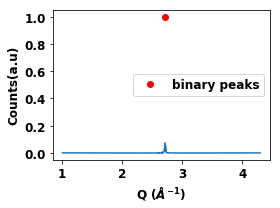

In [15]:
#### Define a function for multi Gaussian fit.
# for j in range(1500):11, 12, 13, 26, 32
plot=plt.figure()
xrd_y=datas[124,:]
ys=signal.savgol_filter(xrd_y,11,5)
base = peakutils.baseline(ys, 1)
indexes = pu.indexes(ys-base, thres=0.1, min_dist=50);
n_xrd_peaks=len(indexes) # Number of peaks identifiedprint j, indexes
plt.plot(q,xrd_y)
plt.plot(q[indexes],np.ones_like(q[indexes]),'ro', label='binary peaks')
plt.legend()
plt.xlabel('Q ($\AA^{-1}$)')
plt.ylabel('Counts(a.u)')
fig = plt.gcf()
fig.set_size_inches(4, 3)
plt.tight_layout()        
plt.savefig('Graphs/binary.pdf', dpi=300)
plt.show() 
plt.close()

In [16]:
XRD_data = datas
xaxis=q
XRD_data_binary=np.zeros_like(XRD_data)
datarows=XRD_data.shape[0]
peaks_data=np.zeros([datarows,63])
for i in range(datarows):
    y=XRD_data[i,:]
    ys=signal.savgol_filter(y,11,5)
    base = peakutils.baseline(ys, 1)
    indexes = pu.indexes(ys-base, thres=0.1, min_dist=50);
    XRD_data_binary[i,indexes]=1
print XRD_data_binary.shape

(1533, 1450)


In [17]:
pts_1450 = np.zeros((XRD_data_binary.shape[0], XRD_data_binary.shape[1]+5))
pts_1450[:, 5:] = XRD_data_binary
pts_1450[:, :2] = xrd_xy
pts_1450[:,2:5] = atomratios
print pts_1450.shape, min(q), max(q)

(1533, 1455) 1.0034114 4.2988629


In [18]:
def check_data():
    data = pts_200
    print 'checking data1:'
    for i in range(data.shape[0]):
            if sum(data[i,5:]) ==0:
                print i
    data = pts_1450
    print 'checking data2:'
    for i in range(data.shape[0]):
            if sum(data[i,5:]) ==0:
                print i

In [19]:
check_data()

checking data1:
checking data2:


In [20]:
def count_peaks(data):
    counter = dict()
    pos = dict()
    for x in range(len(data)):
        num_nz = len([y for y in data[x,5:] if y>0])
        if not counter.has_key(num_nz): 
            counter[num_nz] =0
            pos[num_nz] = []
        counter[num_nz] +=1
        pos[num_nz].append(x)
    print counter

In [21]:
# organizes the data by number of nonzero elements
#
# Input
# data   : a 2-D array of real numbers
# ignore : a positive integer denoting how much of the beginning of each vector in data should be ignored as junk.
#
# Output
# - a 3-D array of real numbers in which each layer contains the data with a specific number of peaks, organized from
#   lowest to highest.
# - a 1-D array of nonnegative integers that represents how many data points are in each layer of the 3-D array.
def organize(data, ignore=5):
    # creates an array to separate the data into the different possible number of peaks
    # also initiates a counter to count how many of each there are.
    organized = np.empty((100, 405, data.shape[1]))
    counters = np.zeros(100, dtype=int)
    
    # runs through all the data, to check to see how many peaks each data point has, and adds it to
    # the correct row of the organized 3-D matrix. Also increases counter to keep track.
    peaks_set = set()
    for i in range(len(data)):
        peaks = len([x for x in data[i, ignore:] if x > 0])
        peaks_set.add(peaks)
        organized[peaks, counters[peaks]] = data[i,:]
        counters[peaks] += 1
    print 'num peaks in the dataset:', peaks_set
    max_peaks = max(peaks_set)
    min_peaks = min(peaks_set)
    return organized[min_peaks:max_peaks+1,:,:], counters[min_peaks:max_peaks+1]

In [22]:
# runs the dynamic time warping distance calculation and returns a true/false output
#
# Input
# vector1       : a 1-D array you wish to perform dtw on.
# vector2       : a 1-D array you wish to perform dtw on.
# thresh_equals : maximum distance at which vector1 and vector2 can be considered equal.
#
# Output
# - a boolean value that denotes whether or not vector1 and vector2 are equal
def use_dtw(vector1, vector2):
    f = lambda x, y: abs(x-y)
    d, c, a, p = dtw(vector1.reshape(-1,1), vector1.reshape(-1,1), f)
    
    return d

In [23]:
# runs the earth mover's distance calculation and returns a true/false output
#
# Input
# vector1       : a 1-D array you wish to perform emd on .
# vector2       : a 1-D array you wish to perform emd on .
# thresh_equals : maximum distance at which vector1 and vector2 can be considered equal.
#
# Output
# - a boolean value that denotes whether or not vector1 and vector2 are equal
def use_emd(vector1, vector2):
    dist = np.empty([len(vector1), len(vector2)])
    for i in range(len(vector1)):
        for j in range(len(vector2)):
            dist[i,j] = abs(i-j)
            
    d = emd(vector1, vector2, dist)
    
    return d

In [24]:
# Plots a set of data on a ternary plot with colors corresponding to their labels.
#
# Input
# data    : a 2-D array of data that contains ternary coordinates.
# labels  : a 1-D array of integers that denotes the cluster each corresponding data belongs to.
#
# Output
# - nothing. Plots the ternary data.
def show_ternary1(data, labels):
    #return
    scale =100
    points=data[:,[3,4,2]]
    #points = np.fliplr(points)
    #points=np.roll(points,2,axis=1)
    
    print data.shape
    #print data[:, 2:5]
    pts_k = labels
    figure0, tax = ternary.figure(scale=scale)
    figure0.set_size_inches(10, 10)
    # Draw Boundary and Gridlines
    tax.boundary(linewidth=2.0)
    tax.gridlines(color='k', multiple=10)
    # Set Axis labels and Title
    fontsize = 20
    unique, c = np.unique(labels, return_counts=True)
    tax.set_title('Number of clusters = '+str(len(unique)), fontsize=15)
    tax.left_axis_label("$Co\ (at\ \\%)$", fontsize=12)
    tax.right_axis_label("$Ta\ (at\ \\%)$", fontsize=12)
    tax.bottom_axis_label("$Ni\ (at\ \\%)$", fontsize=12,offset=-0.07)
    tax.scatter(points=points,marker='o',c=pts_k,vmax=pts_k.max(),vmin=pts_k.min(),
                cmap='prism_r',s=[30]*data.shape[0],linewidths=0,alpha=.8);
    tax.ticks(axis='lrb', multiple=10,linewidth=1)
    #tax.clear_matplotlib_ticks()
    tax.show()

In [25]:
def getxy(atomic_ratios):
    xy = np.zeros((atomic_ratios.shape[0],2))
    xy[:,0] = 0.5*(2*atomic_ratios[:,0]+atomic_ratios[:,1])
    xy[:,1] = 0.5 * 3**.5*atomic_ratios[:,1]
    return xy

In [26]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier as RFC
#from mlxtend.plotting import plot_decision_regions
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
def correlate(X, y):
    clf = SVC(C=0.05, kernel='linear')
    #clf = MLPClassifier()
    clf.fit(X,y)
    return clf.predict(X)

In [27]:
# Plots a set of data on a ternary plot with colors corresponding to their labels.
#
# Input
# data    : a 2-D array of data that contains ternary coordinates.
# labels  : a 1-D array of integers that denotes the cluster each corresponding data belongs to.
#
# Output
# - nothing. Plots the ternary data.
def show_ternary_all(data, labels, ignore=5):
    #return
    scale =100
    labels = np.asarray(labels, dtype=np.int32)
    #points=np.roll(data,-1,axis=1)
    points=data[:,[3,4,2]]
    #points = np.fliplr(points)
    #points=np.roll(points,2,axis=1)
    
    print data.shape
    #print data[:, 2:5]
    pts_k = labels
    figure0, tax = ternary.figure(scale=scale)
    figure0.set_size_inches(10, 10)
    # Draw Boundary and Gridlines
    tax.boundary(linewidth=2.0)
    tax.gridlines(color='k', multiple=10)
    # Set Axis labels and Title
    fontsize = 20
    unique, c = np.unique(labels, return_counts=True)
    tax.set_title('Number of clusters = '+str(len(unique)), fontsize=15)
    tax.left_axis_label("$Co\ (at\ \\%)$", fontsize=12)
    tax.right_axis_label("$Ta\ (at\ \\%)$", fontsize=12)
    tax.bottom_axis_label("$Ni\ (at\ \\%)$", fontsize=12,offset=-0.07)
    
    markers=('o','v','<','>','p','*','h','H','D','d','o','v','<','>','s','p','*','h','H','D','d')
    total_clusters = np.unique(labels).shape[0]
    colors = plt.cm.rainbow(np.linspace(0, 1, total_clusters))
    while len(markers)< total_clusters: markers = markers + markers

    peak_counts = np.zeros(10, dtype=int)
    all_pd = {}
    for i in range(data.shape[0]):
        num_peaks = len(np.nonzero(data[i,ignore:])[0])
        peak_counts[num_peaks]+=1
        if not num_peaks in all_pd: all_pd[num_peaks] = [i]
        else: all_pd[num_peaks].append(i)
    #markers = '_|o^v+x*sD'
    markers=('o','v','<','>','p','*','h','H','D','d','o','v','<','>','s','p','*','h','H','D','d')
    offset = 0
    
    for i in range(10):
        if not i in all_pd: continue
        pc_inds = all_pd[i]
        points_p = points[pc_inds]
        pts_k = labels[pc_inds]
        for l in set(pts_k):
            marker = markers[l]
            inds = np.where(pts_k==l)[0]
            tax.scatter(points=points_p[inds],marker=marker,c=pts_k[inds],vmax=pts_k.max(),vmin=pts_k.min(),
                cmap='prism_r',s=[50]*points_p.shape[0],linewidths=0,alpha=.8, edgecolor='w');
    tax.ticks(axis='lbr', multiple=10,linewidth=1)
    tax.clear_matplotlib_ticks()
    tax.show()

In [28]:
# Plots a set of data on a ternary plot with colors corresponding to their labels.
#
# Input
# data    : a 2-D array of data that contains ternary coordinates.
# labels  : a 1-D array of integers that denotes the cluster each corresponding data belongs to.
#
# Output
# - nothing. Plots the ternary data.
def show_ternary_all_points(data, labels, ignore=5):
    scale =100
    #points=np.roll(data,-1,axis=1)
    points=data[:,[3,4,2]]
    
    print data.shape
    #print data[:, 2:5]
    pts_k = labels
    
    print np.unique(labels)
    peak_counts = np.zeros(10, dtype=int)
    all_pd = {}
    for i in range(data.shape[0]):
        ca = labels[i, 1:]
        if len(np.where(ca!= -1)[0]): continue
        if -1 ==labels[i,0]: continue
        num_peaks = len(np.nonzero(data[i,ignore:])[0])
        peak_counts[num_peaks]+=1
        if not num_peaks in all_pd: all_pd[num_peaks] = [i]
        else: all_pd[num_peaks].append(i)
    markers = '_|o^v+x*sD'
    markers=('o','v','<','>','p','*','h','H','D','d','o','v','<','>','s','p','*','h','H','D','d')
    total_clusters = np.unique(labels).shape[0]
    colors = plt.cm.rainbow(np.linspace(0, 1, total_clusters))
    while len(markers)< total_clusters: markers = markers + markers
    

    
    print 'plotting ternary of points showing their first pure phase component'
    figure0, tax = ternary.figure(scale=scale)
    figure0.set_size_inches(10, 10)
    # Draw Boundary and Gridlines
    tax.boundary(linewidth=2.0)
    tax.gridlines(color='k', multiple=10)
    # Set Axis labels and Title
    fontsize = 20
    unique, c = np.unique(labels, return_counts=True)
    tax.set_title('Number of clusters = '+str(len(unique)), fontsize=15)
    tax.left_axis_label("$Co\ (at\ \\%)$", fontsize=12)
    tax.right_axis_label("$Ta\ (at\ \\%)$", fontsize=12)
    tax.bottom_axis_label("$Ni\ (at\ \\%)$", fontsize=12,offset=-0.07)
    for i in range(10):
        if not i in all_pd: continue
        pc_inds = all_pd[i]
        points_p = points[pc_inds]
        pts_k = labels[pc_inds,0]
        tax.scatter(points=points_p,marker=markers[i],c=pts_k,vmax=pts_k.max(),vmin=pts_k.min(),
                cmap='prism_r',s=[50]*points_p.shape[0],linewidths=0,alpha=.8, edgecolor='w');
    tax.ticks(axis='lbr', multiple=10,linewidth=1)
    tax.clear_matplotlib_ticks()
    tax.show()

In [29]:
data = pts_200
print 'checking data:'
for i in range(data.shape[0]):
        if sum(data[i,5:]) ==0:
            print i
data = pts2_200
print 'checking data:'
for i in range(data.shape[0]):
        if sum(data[i,5:]) ==0:
            print i



checking data:
checking data:


In [30]:
# a function to plot the color-coded clusters determined from the pure phase representatives determined by find_pure
# data     : a 2-D array of real numbers representing the data to be plotted
# labels   : a 1-D array of positive integers represeting the labels of the data
# interval : a positive integer representing the number of peaks in this dataset
def show_pure_clusters(pure_data, set_pure_labels, titles, ignore=5):
    # creates a list of colors, the number of which is equal to the number of clusters
    print "Potential Pure Phases Before Clustering: ", len(pure_data)
    data = pure_data
    peak_counts = np.zeros(10, dtype=int)
    set_pure_labels = np.array(set_pure_labels)
    pure_pd = {}
    total_data = 0
    for i in range(pure_data.shape[0]):
        num_peaks = len(np.nonzero(data[i,ignore:])[0])
        peak_counts[num_peaks]+=1
        if not num_peaks in pure_pd: pure_pd[num_peaks] = [i]
        else: pure_pd[num_peaks].append(i)
        total_data+=1
    print peak_counts
    #print 'total point to plot: ', total_data
    num_sp = set_pure_labels.shape[0]
    fig, ax  = plt.subplots(1, set_pure_labels.shape[0])
    
    offset = 0
    markers = '_|o^v+x*sD'
    markers=('o','v','<','>','p','*','H','D','d','o','v','<','>','s','p','*','H','D','d')
    total_clusters = np.unique(set_pure_labels).shape[0]
    colors = plt.cm.rainbow(np.linspace(0, 1, total_clusters))
    while len(markers)< total_clusters: markers = markers + markers

    ind_c = [0]*num_sp
    for k, peak_c in enumerate(peak_counts):
        if not peak_c: continue
        marker = markers[k]
        pc_inds = pure_pd[k]
        data_p = data[pc_inds, :]
        labels = set_pure_labels[:,pc_inds]
        #print 'number of peaks: %d num pure_phase: %d'%(k, peak_c)
        #print pc_inds
        #scatter_plot([data for _ in range(labels_p.shape[0])], labels_p, titles)
        for i in range(num_sp):
            offset_sp = offset
            l1=ax[i].axhline(offset_sp-0.5,color='black',ls=':', lw=0.2)
            #ax[i].plot(0, offset_sp, 205, offset_sp, color='r', linestyle='--')
            num_labels = len(set(labels[i]))
            #colors = plt.cm.rainbow(np.linspace(0, 1, num_labels))
            #print labels[i]
            ind = 0
            #print offset, num_labels
            for j, c in zip(set(labels[i]), colors[ind_c[i]:ind_c[i]+num_labels]):
                locs = np.where(labels[i]==j)[0]
                #print 'locs: ', locs, len(locs)
                marker = markers[ind_c[i]+ind]
                ind+=1
                coords = np.where(data_p[locs,5:]>0)
                #print coords
                coords0 = [x+offset_sp for x in coords[0]]
                #print offset_sp, coords0
                ax[i].scatter(coords[1], coords0, color=c, marker=marker)
                offset_sp += len(locs)
            ind_c[i]+= num_labels 
        offset+=len(pc_inds)
    for i in range(num_sp):
        ax[i].set_xlim(0, 205)
        ax[i].set_ylim(-1, offset)
        ax[i].set_xlabel('Peak position')
        ax[i].set_ylabel('Pure phase [before HC]')
        #num_clusters = len(set(set_pure_labels[i]))
        #print num_clusters, set(set_pure_labels[i])
        ax[i].set_title(titles[i]+' [num_clusters:'+str(ind_c[i])+']')
    fig = plt.gcf()
    fig.set_size_inches(5*num_sp, max(6, total_data/20))
    plt.show()
    
    return


In [31]:
# a function to plot the color-coded clusters determined from the pure phase representatives determined by find_pure
# data     : a 2-D array of real numbers representing the data to be plotted
# labels   : a 1-D array of positive integers represeting the labels of the data
# interval : a positive integer representing the number of peaks in this dataset
def show_pure_clusters_metric(pure_data, set_pure_labels_dict, distance_metric, ignore=5):
    # creates a list of colors, the number of which is equal to the number of clusters
    print "Potential Pure Phases Before Clustering: ", len(pure_data)
    data = pure_data
    peak_counts = np.zeros(10, dtype=int)
    #set_pure_labels = np.array(set_pure_labels)
    pure_pd = {}
    total_data = 0
    for i in range(pure_data.shape[0]):
        num_peaks = len(np.nonzero(data[i,ignore:])[0])
        peak_counts[num_peaks]+=1
        if not num_peaks in pure_pd: pure_pd[num_peaks] = [i]
        else: pure_pd[num_peaks].append(i)
        total_data+=1
    print peak_counts
    #print 'total point to plot: ', total_data
    num_sp = len(set_pure_labels_dict)
    plot_pcol = num_sp if num_sp < 5 else 4
    num_rows = num_sp//plot_pcol if not num_sp%plot_pcol else num_sp//plot_pcol+1
    
    print 'num_sp: %d, plot_pcol:%d, num_rows:%d'%(num_sp, plot_pcol, num_rows)
    fig, ax  = plt.subplots(num_rows, plot_pcol)
    
    if num_sp==1: ax=[ax]
    ax = np.reshape(ax, -1)
    
    
    offset = 0
    markers = '_|o^v+x*sD'
    markers=('o','v','<','>','p','*','H','D','d','o','v','<','>','s','p','*','H','D','d')
    total_clusters = np.unique(set_pure_labels_dict.values()).shape[0]
    colors = plt.cm.rainbow(np.linspace(0, 1, total_clusters))
    while len(markers)< total_clusters: markers = markers + markers

    ind_c = [0]*num_sp
    for k, peak_c in enumerate(peak_counts):
        if not peak_c: continue
        marker = markers[k]
        pc_inds = pure_pd[k]
        data_p = data[pc_inds, :]
        #labels = set_pure_labels[:,pc_inds]
        #print 'number of peaks: %d num pure_phase: %d'%(k, peak_c)
        #print pc_inds
        #scatter_plot([data for _ in range(labels_p.shape[0])], labels_p, titles)
        i=-1
        #print type(set_pure_labels_dict)
        #print set_pure_labels_dict.keys()
        for hc_param in sorted(set_pure_labels_dict.keys(), reverse=True):
            labels = set_pure_labels_dict[hc_param]
            i+=1
            offset_sp = offset
            labels = labels[pc_inds]
            l1=ax[i].axhline(offset_sp-0.5,color='black',ls=':', lw=0.2)
            #ax[i].plot(0, offset_sp, 205, offset_sp, color='r', linestyle='--')
            num_labels = len(set(labels))
            #colors = plt.cm.rainbow(np.linspace(0, 1, num_labels))
            #print labels[i]
            ind = 0
            #print offset, num_labels
            for j, c in zip(set(labels), colors[ind_c[i]:ind_c[i]+num_labels]):
                locs = np.where(labels==j)[0]
                #print 'locs: ', locs, len(locs)
                marker = markers[ind_c[i]+ind]
                ind+=1
                coords = np.where(data_p[locs,5:]>0)
                #print coords
                coords0 = [x+offset_sp for x in coords[0]]
                #print offset_sp, coords0
                ax[i].scatter(coords[1], coords0, color=c, marker=marker)
                offset_sp += len(locs)
            ind_c[i]+= num_labels 
        offset+=len(pc_inds)
    hc_params = sorted(set_pure_labels_dict.keys(), reverse=True)
    for i in range(num_sp):
        ax[i].set_xlim(0, 205)
        ax[i].set_ylim(-1, offset)
        ax[i].set_xlabel('Peak position')
        ax[i].set_ylabel('Pure phase [before HC]')
        #num_clusters = len(set(set_pure_labels[i]))
        #print num_clusters, set(set_pure_labels[i])
        ax[i].set_title(distance_metric+' [nc:'+str(ind_c[i])+', hc_param:'+str(hc_params[i])+']')
    fig = plt.gcf()
    fig.set_size_inches(4*plot_pcol, max(6, num_rows*6))
    plt.show()
    
    return



In [32]:
# a function to plot the color-coded clusters determined from the pure phase representatives determined by find_pure
# data     : a 2-D array of real numbers representing the data to be plotted
# labels   : a 1-D array of positive integers represeting the labels of the data
# interval : a positive integer representing the number of peaks in this dataset
def show_pure_clusters_all(pure_data, set_pure_labels, titles, ignore=5):
    # creates a list of colors, the number of which is equal to the number of clusters
    #print "Potential Pure Phases Before Clustering: ", len(pure_data),
    data = pure_data
    peak_counts = np.zeros(10, dtype=int)
    set_pure_labels = np.array(set_pure_labels)
    #print set_pure_labels.shape
    pure_pd = {}
    total_data = 0
    for i in range(pure_data.shape[0]):
        ca = set_pure_labels[:,i, 1:]
        if -1 in set_pure_labels[:,i, 0]: continue
        if len(np.where(ca!= -1)[0]): continue
        num_peaks = len(np.nonzero(data[i,ignore:])[0])
        peak_counts[num_peaks]+=1
        if not num_peaks in pure_pd: pure_pd[num_peaks] = [i]
        else: pure_pd[num_peaks].append(i)
        total_data+=1
    #print peak_counts
    #print 'total data to plot: ', total_data
    num_sp = set_pure_labels.shape[0]
    fig, ax  = plt.subplots(1, set_pure_labels.shape[0])
    total_clusters = np.unique(set_pure_labels).shape[0]
    colors = plt.cm.rainbow(np.linspace(0, 1, total_clusters))
    
    offset = 0
    markers = '_|o^v+x*sD'
    markers=('o','v','<','>','p','*','h','H','D','d','o','v','<','>','s','p','*','H','D','d')
    while len(markers)< total_clusters: markers = markers + markers

    ind_c = [0] * num_sp
    print 'plotting scatter plot of points showing their first pure phase component'
    for k, peak_c in enumerate(peak_counts):
        if not peak_c: continue
        #marker = markers[k]
        pc_inds = pure_pd[k]
        data_p = data[pc_inds, :]
        labels = set_pure_labels[:,pc_inds,0]
        #print 'number of peaks: %d num points: %d'%(k, peak_c),
        #print 'labels ', np.unique(labels)
        #scatter_plot([data for _ in range(labels_p.shape[0])], labels_p, titles)
        for i in range(num_sp):
            offset_sp = offset
            l1=ax[i].axhline(offset_sp-0.5,color='black',ls=':')
            #ax[i].plot(0, offset_sp, 205, offset_sp, color='r', linestyle='--')
            num_labels = len(set(labels[i]))
            #colors = plt.cm.rainbow(np.linspace(0, 1, num_labels))
            ind=0
            for j, c in zip(set(labels[i]), colors[ind_c[i]: ind_c[i]+num_labels]):
                locs = np.where(labels[i]==j)[0]
                marker = markers[ind_c[i]+ind]
                ind+=1
                #print 'locs: ', locs, len(locs)
                coords = np.where(data_p[locs,5:]>0)
                #print coords
                coords0 = [x+offset_sp for x in coords[0]]
                #print offset_sp, coords0
                ax[i].scatter(coords[1], coords0, color=c, marker=marker)
                offset_sp += len(locs)
            ind_c[i]+= num_labels
        offset+=len(pc_inds)
        
    for i in range(num_sp):
        ax[i].set_xlim(0, 205)
        ax[i].set_ylim(0, offset)
        ax[i].set_xlabel('Peak position')
        ax[i].set_ylabel('Pure phase [before HC]')
        #num_clusters = len(set(set_pure_labels[i,:,0]))
        #print num_clusters, set(set_pure_labels[i,:,0])
        
        #print num_clusters
        ax[i].set_title(titles[i]+'[num_clusters:'+str(ind_c[i])+']')
    fig = plt.gcf()
    fig.set_size_inches(5*num_sp, max(6, total_data/100))
    plt.show()
    return

In [33]:
def show_circular(data, label_set,titles, ignore=5):
    label_set = np.array(label_set)
    num_sp = label_set.shape[0]
    fig, ax  = plt.subplots(1,num_sp)
    print label_set.shape, num_sp, len(ax)
    
    peak_counts = np.zeros(10, dtype=int)
    all_pd = {}
    total_points = 0
    for i in range(data.shape[0]):
        if len(label_set.shape) > 2:
            ca = label_set[:,i, 1:]
            if -1 in label_set[:,i, 0]: continue
        
            if len(np.where(ca!= -1)[0]): continue
        num_peaks = len(np.nonzero(data[i,ignore:])[0])
        peak_counts[num_peaks]+=1
        total_points +=1
        if not num_peaks in all_pd: all_pd[num_peaks] = [i]
        else: all_pd[num_peaks].append(i)
    print 'total points with pure phases: ', total_points
    markers = '_|o^v+x*sD'
    markers=('o','v','<','>','p','*','H','D','d','o','v','<','>','s','p','*','H','D','d')
    total_clusters = np.unique(label_set).shape[0]
    colors = plt.cm.jet(np.linspace(0, 1, total_clusters))
    while len(markers)< total_clusters: markers = markers + markers


    offset=0

    if len(label_set.shape) > 2:
        label_set = label_set[:, :,0]
    
    ind_c = [0] * num_sp
    for i in range(num_sp):
        #circle1 = plt.Circle((0, 0), 52, color='ivory', edgecolor='k', alpha=0.5)
        #circle2 = plt.Circle((0, 0), 52, color='ivory', edgecolor='k', fill=False)
        #ax[i].add_artist(circle1)
        #ax[i].add_artist(circle2)
        circle1=plt.Circle((0,0),51,edgecolor='k',lw=1,facecolor='None')
        plt.axes(ax[i])
        plt.gcf().gca().add_artist(circle1)
        
        offset=0
        for k, peak_c in enumerate(peak_counts):
            if not peak_c: continue
            marker = markers[k]
            pc_inds = all_pd[k]
            data_p = data[pc_inds, :]
            labels = label_set[i,pc_inds]
            num_labels = len(set(labels))
            #colors = plt.cm.rainbow(np.linspace(0, 1, num_labels))
            for j, c in zip(set(labels), colors[offset:offset+num_labels]):
                locs = np.where(labels==j)[0]
                #print 'locs: ', locs
                #coords = np.where(data[i][locs,5:]>0)
                #print coords[2], coords[1]
                #ax[i].scatter(coords[2], coords[1], color=c)
                marker = markers[offset]
                xy = data_p[locs, :2]
                #print 'xy:', xy.shape, xy
                ax[i].scatter(xy[:,0], xy[:,1], marker= marker,
                             s=[50]*len(locs),
                              color=c, edgecolor='k',label='np:%d'%(k), alpha=0.8, lw=0.2)
                offset+=1
        ax[i].set_xlabel('x (mm)')
        ax[i].set_ylabel('y (mm)')
        ax[i].set_xlim(-55,55)
        #plt.legend(ncol=4, loc='upper right')
        ax[i].legend(loc='upper center', bbox_to_anchor=(0.5, 0),
          ncol=6, fancybox=True, shadow=True)
        ax[i].set_ylim(-55,55)
        ax[i].set_aspect('equal')
        ax[i].set_title(titles[i]+'[num_clusters:'+str(offset)+']')
    fig = plt.gcf()
    fig.set_size_inches(6*num_sp,8)
    plt.tight_layout()
    plt.show()
    plt.close()

In [34]:
from collections import defaultdict
def peak_counts(data, ignore=5):
    pd = defaultdict(list)
    pc = np.zeros(30, dtype=int)
    for i in range(data.shape[0]):
        npk = len(np.nonzero(data[i, ignore:])[0])
        pc[npk]+=1
        pd[npk].append(i)
    print data.shape, pc, len(pd[2])
    return pd, pc

In [35]:
g_s=100
g_alpha=1.
g_lw=.2

In [36]:
def ax_scatter(data, labels, ax = None, colors= None, markers=None, fig_name=None, save_dir=None, ignore=5):
    fig=None
    if ax is None:
        fig, ax = plt.subplots(1,1)
    pure_pd, pcounts = peak_counts(data)
    unique, c = np.unique(labels, return_counts=True)
    total_clusters = len(unique)
    labels = np.asarray(labels)
    
    if colors is None:
        colors = plt.cm.rainbow(np.linspace(0, 1, total_clusters+1))
    if markers is None:
        markers=('.','o','v','<','>','*','H','D','d','o','v','<','>','s','p','*','H','D','d')
        while len(markers)< total_clusters+1: markers = markers + markers
        
    offset=0
    offset_p=0
    for k, peak_c in enumerate(pcounts):
        if not peak_c: continue
        ppc_inds = pure_pd[k]
        pure_labels_p = labels[ppc_inds]
        pure_d = data[ppc_inds]
        for j in set(pure_labels_p):
            c = colors[j]
            pure_locs = np.where(pure_labels_p==j)[0]
            coords = np.where(pure_d[pure_locs,5:]>0)
            coords0 = coords[0]
            coords0 = [x+offset_p for x in coords[0]]
            marker = markers[j]
            ax.scatter(coords[1], coords0, s=[g_s]*len(pure_locs), edgecolor='k', color=c, marker=marker, alpha=g_alpha, lw=g_lw)
            offset_p+= len(pure_locs)
        l1=ax.axhline(offset_p-0.5,color='black',ls=':', lw=.5, alpha=1)
    ax.set_xlim(0, data.shape[1])
    ax.set_ylim(-.5, offset_p+1)
    ax.set_xlabel('Peak position')
    ax.set_ylabel('Pure phase')
    
    plt.tight_layout()
    if fig_name:
        fig = plt.gcf()
        fig.set_size_inches(5, 10)
        os.system('mkdir -p '+save_dir)
        fig_path = os.path.join(save_dir, fig_name)
        plt.savefig(fig_path)
        print 'saved to ', fig_path
        plt.show()
        plt.close()
    #else:
    #plt.show()
    return

ax ternary: (1724, 205)
ternary..labels: [1 2] [1355  369]
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
ax ternary: (1729, 205)
ternary..labels: [1 2] [1360  369]
(1729, 205) [  5   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398


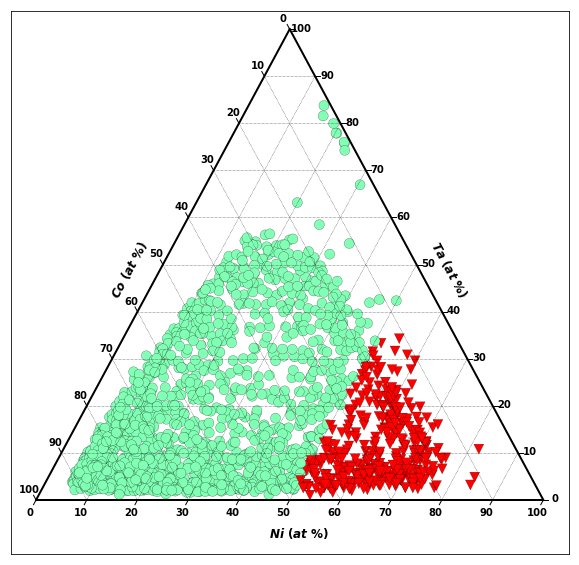

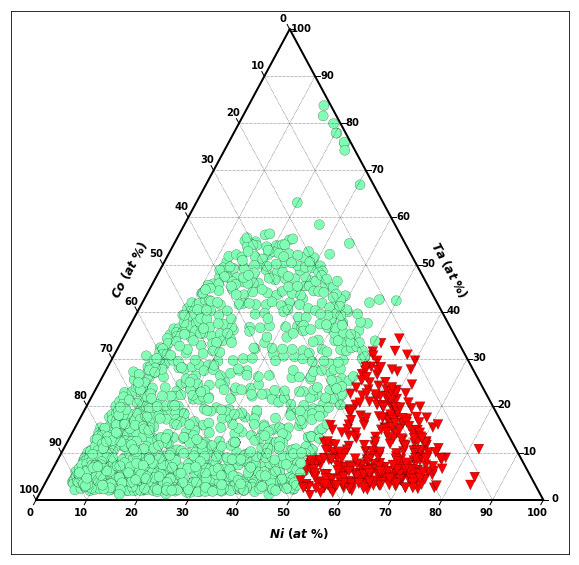

In [37]:
# Plots a set of data on a ternary plot with colors corresponding to their labels.
#
# Input
# data    : a 2-D array of data that contains ternary coordinates.
# labels  : a 1-D array of integers that denotes the cluster each corresponding data belongs to.
#
# Output
# - nothing. Plots the ternary data.
import matplotlib.tri as tri
def ax_ternary(data, labels, ax=None, contour=False, colors=None, markers=None, plot_points=True, fig_name=None, save_dir=None, pure_only=False):
    scale =100
    if data.shape[1]==205:
        points=data[:,[2,4,3]]
    elif data.shape[1]==1455:
        points=data[:,[2,3,4]]
    labels = np.asarray(labels, dtype=np.int32).reshape((labels.shape[0],-1))
    print 'ax ternary:',data.shape
    #print data[:, 2:5]
    if ax is None:
        figure0, tax = ternary.figure(scale=scale)
        figure0.set_size_inches(10, 10)
        ax = tax.get_axes()
    else:
        print 'using existing axis'
        figure, tax = ternary.figure(ax=ax, scale=scale)
    # Draw Boundary and Gridlines
    tax.boundary(linewidth=2.0)
    tax.gridlines(color='k', multiple=10)
    # Set Axis labels and Title
    
    unique, c = np.unique(labels, return_counts=True)
    print 'ternary..labels:', unique, c
    total_clusters = len(unique)
    
    if colors is None:
        colors = plt.cm.rainbow(np.linspace(0, 1, total_clusters+1))
    if markers is None:
        markers=('.','o','v','<','>','*','H','D','d','o','v','<','>','s','p','*','H','D','d')
        while len(markers)< total_clusters+1: markers = markers + markers
    if contour:
        xy = getxy(points)
        X = xy
        y = labels
        T = tri.Triangulation(xy[:,0], xy[:,1])
        plt.tricontourf(xy[:,0],xy[:,1],T.triangles, labels[:,0], colors = colors[:total_clusters], alpha=alpha, corner_mask=False, linewidths=2.)
    #tax.set_title('Number of clusters = '+str(len(unique)-1), fontsize=15)
    if data.shape[1]==205:
        tax.left_axis_label("$Co\ (at\ \\%)$", fontsize=12)
        tax.right_axis_label("$Ta\ (at\ \\%)$", fontsize=12)
        tax.bottom_axis_label("$Ni\ (at\ \\%)$", fontsize=12,offset=-0.07)
    elif data.shape[1]==1455:
        tax.left_axis_label("$Ti\ (at\ \\%)$", fontsize=12)
        tax.right_axis_label("$Co\ (at\ \\%)$", fontsize=12)
        tax.bottom_axis_label("$Ta\ (at\ \\%)$", fontsize=12,offset=-0.07)
       
    else: return
    if plot_points:
        all_pd, _ = peak_counts(data)
        offset = 0
        for i in range(30):
            if not i in all_pd: continue
            pc_inds = all_pd[i]
            points_p = points[pc_inds]
            pts_k = labels[pc_inds, 0]
            for l in set(pts_k):
                if l==-1: continue
                marker = markers[l]
                c = colors[l]
                inds = np.where(pts_k==l)[0]
                if len(inds)<1: continue
                tax.scatter(points=points_p[inds],marker=marker,c=colors[l],
                 s=[g_s]*points_p.shape[0],linewidths=g_lw,alpha=g_alpha, edgecolor='k');
    for i in range(data.shape[0]):
        if pure_only: break
        if labels.shape[1]==1: break
        lab = labels[i].astype(int)
        lab = set([x for x in lab if x!=-1])
        if len(lab) <=1: continue
        sf = 0.
        alph = .6/len(lab)
        s=g_s*len(lab)
        for l in lab:
            sf +=1
            marker = markers[l]
            tax.scatter([points[i]], marker=marker, s=s/sf, color=colors[l], edgecolor='k', 
                        alpha=.2+alph*sf, lw=g_lw*2)
    tax.ticks(axis='lbr', multiple=10,linewidth=1)
    tax.clear_matplotlib_ticks()
    
    if fig_name:
        fig = plt.gcf()
        fig.set_size_inches(10, 10)
        os.system('mkdir -p '+save_dir)
        fig_path = os.path.join(save_dir, fig_name)
        plt.savefig(fig_path)
        print 'saved to ', fig_path
        plt.show()
        plt.close()
    #else:
    #plt.show()
    return
    #tax.show()
    #tax.close()
labels = np.ones(pts_200.shape[0])
labels[np.where(pts_200[:,2]>50)] = 2
ax_ternary(pts_200, labels)
labels = np.ones(xrd_data.shape[0])
labels[np.where(xrd_data[:,2]>50)] = 2
ax_ternary(xrd_data, labels)
#print d

In [38]:
def ax_circular(data, labels, ax = None, colors= None, markers=None, pure_only=False, fig_name=None, save_dir=None, ignore=5):
    fig=None
    if ax is None:
        fig, ax = plt.subplots(1,1)
    all_pd, pcounts = peak_counts(data)
    unique, c = np.unique(labels, return_counts=True)
    total_clusters = len(unique)
    data_labels = labels
    all_data = data
    
    if colors is None:
        colors = plt.cm.rainbow(np.linspace(0, 1, total_clusters+1))
    if markers is None:
        markers=('.','o','v','<','>','*','H','D','d','o','v','<','>','s','p','*','H','D','d')
        while len(markers)< total_clusters+1: markers = markers + markers
    
    
    offset=0
    offset_p=0
    
    circle1=plt.Circle((0,0),51,edgecolor='k',lw=1,facecolor='None')
    ax.add_artist(circle1)
    num_outliers = 0
    num_pp = 0
    num_mp = 0        
    offset=0
    label_marker = {}
    label_color = {}
        
    for k, peak_c in enumerate(pcounts):
        if not peak_c: continue
        apc_inds = all_pd[k]
        del_ind = []
        for pci in apc_inds:
            ca = [x for x in data_labels[pci, :].astype(int) if x!=-1]
            ca = set(ca)
            if len(ca)==1:
                num_pp+=1
                continue
            if len(ca) > 1:
                num_mp+=1
                del_ind.append(pci)
                continue
            if not len(ca):
                num_outliers +=1
                del_ind.append(pci)
                continue
        apc_inds = [x for x in apc_inds if x not in del_ind]
        data_p = all_data[apc_inds, :]
        labels_p = labels[apc_inds,0].astype(int)

        for j in set(labels_p):
            c = colors[j]
            data_locs = np.where(labels_p==j)[0]
            xy = data_p[data_locs, :2]
            marker = markers[j]
            label_marker[int(j)] = marker
            label_color[int(j)] = c
            ax.scatter(xy[:,0], xy[:,1], marker= marker,
                         s=[g_s]*len(data_locs),
                          color=c, edgecolor='k',label='np:%d'%(k), alpha=g_alpha, lw=g_lw)

    print 'pp: %d mp: %d outliers: %d'%(num_pp, num_mp, num_outliers)
            
    for i in range(data.shape[0]):
        if pure_only: break
        xy = data[i,:2]
        lab = labels[i].astype(int)
        lab = set([x for x in lab if x!=-1])
        if len(lab) <=1: continue
        sf = 0.
        alph = .8/len(lab)
        s = 50. if len(lab)>1 else 50.
        s=g_s*len(lab)
        try:
            for l in lab:
                sf +=1
                marker = label_marker[l]
                c = label_color[l]
                ax.scatter(xy[0], xy[1], marker=marker, s=s/sf, color=c, edgecolor='k',
                            label=str(lab), alpha=.2+alph*sf, lw=g_lw*2)
        except: continue

    ax.set_xlabel('x (mm)')
    ax.set_ylabel('y (mm)')
    ax.set_xlim(-55,55)
    ax.set_ylim(-55,55)
    ax.set_aspect('equal')
    if fig_name:
        fig = plt.gcf()
        fig.set_size_inches(5, 10)
        os.system('mkdir -p '+save_dir)
        fig_path = os.path.join(save_dir, fig_name)
        plt.savefig(fig_path)
        print 'saved to ', fig_path
        plt.show()
        plt.close()
    #else:
    #plt.show()
    return

In [39]:
def dynamic_plot(pures, pure_labels_list, data, all_labels_list, plot_types = ['circular', 'pures', 'triangular'],
                 ignore=5, correlate=False, contour=False, pure_only=True, plot_points=True, fig_name=None, save_dir='Graphs'): 
    pure_pd = {}
    total_pures = 0
    pure_pd, ppeak_counts = peak_counts(pures)
    
    all_pd, apeak_counts = peak_counts(data)
    
    num_sp = len(pure_labels_list)
    num_rows = num_sp
    ncol= len(plot_types)*8
    
    gs = gridspec.GridSpec(num_rows, ncol)
    
    for row in range(num_sp):
        pure_labels = pure_labels_list[row]
        data_labels = all_labels_list[row]
        pure_labels = np.array(pure_labels).astype(int)
        data_labels = np.array(data_labels).astype(int)
        col = 0
        markers=('o','v','<','>','*','H','D','d','o','v','<','>','s','p','*','H','D','d')
        total_clusters = np.unique(pure_labels).shape[0]
        colors = plt.cm.rainbow(np.linspace(0, 1, total_clusters+1))
        while len(markers)< total_clusters+1: markers = markers + markers

        for ptype in plot_types:
            if ptype=='triangular':
                ax = plt.subplot(gs[row, col:col+8])
                ax_ternary(data, data_labels, ax=ax, contour=False, colors=colors, markers=markers, plot_points=plot_points, pure_only=pure_only)
                col+=8
                pass
            if ptype=='pures':
                ax = plt.subplot(gs[row, col:col+8])
                ax_scatter(pures, pure_labels, ax = ax, colors= colors, markers=markers, fig_name=None, save_dir=None, ignore=5)
                col+=8    
                pass
            if ptype=='circular':
                ax = plt.subplot(gs[row, col:col+8])
                ax_circular(data, data_labels, ax=ax, colors= colors, markers=markers, pure_only=pure_only, fig_name=None, save_dir=None, ignore=5)
                col+=8
                pass
            
    fig = plt.gcf()
    fig.set_size_inches(ncol/8*5, num_rows*5)
    plt.tight_layout()
    if fig_name:
        os.system('mkdir -p '+save_dir)
        fig_path = os.path.join(save_dir, fig_name)
        plt.savefig(fig_path)
        print 'saved to ', fig_path
    plt.show()
    
    plt.close()

In [40]:
def show_circular_metric(data, set_pure_labels_dict, distance_metric, ignore=5):
    peak_counts = np.zeros(10, dtype=int)
    all_pd = {}
    total_points = 0
    for i in range(data.shape[0]):
        #if len(label_set.shape) > 2:
        #    ca = label_set[:,i, 1:]
        #    if -1 in label_set[:,i, 0]: continue
        #
        #    if len(np.where(ca!= -1)[0]): continue
        num_peaks = len(np.nonzero(data[i,ignore:])[0])
        peak_counts[num_peaks]+=1
        total_points +=1
        if not num_peaks in all_pd: all_pd[num_peaks] = [i]
        else: all_pd[num_peaks].append(i)
    print 'total points: ', total_points
    print 'peak_counts:', peak_counts
    
    num_sp = len(set_pure_labels_dict)
    plot_pcol = num_sp if num_sp < 2 else 2
    num_rows = num_sp//plot_pcol if not num_sp%plot_pcol else num_sp//plot_pcol+1
    
    print 'num_sp: %d, plot_pcol:%d, num_rows:%d'%(num_sp, plot_pcol, num_rows)
    fig, ax  = plt.subplots(num_rows, plot_pcol)
    if num_sp==1: ax=[ax]
    ax = np.reshape(ax, -1)
    
    
    markers = '_|o^v+x*sD'
    markers=('o','v','<','>','p','*','H','D','d','o','v','<','>','s','p','*','H','D','d')
    total_clusters = np.unique(set_pure_labels_dict.values()).shape[0]
    colors = plt.cm.rainbow(np.linspace(0, 1, total_clusters))
    while len(markers)< total_clusters: markers = markers + markers


    offset=0

    #if len(label_set.shape) > 2:
    #    label_set = label_set[:, :,0]
    
    ind_c = [0] * num_sp
    i=-1
    for hc_param in sorted(set_pure_labels_dict.keys(), reverse=True):
        label_all = set_pure_labels_dict[hc_param]
        i+=1
        #circle1 = plt.Circle((0, 0), 52, color='ivory', edgecolor='k', alpha=0.5)
        #circle2 = plt.Circle((0, 0), 52, color='ivory', edgecolor='k', fill=False)
        #ax[i].add_artist(circle1)
        #ax[i].add_artist(circle2)
        circle1=plt.Circle((0,0),51,edgecolor='k',lw=1,facecolor='None')
        #print 'value of i:',i, len(ax)
        #plt.axes(ax[i])
        #plt.gcf().gca().add_artist(circle1)
        ax[i].add_artist(circle1)
        
        offset=0
        for k, peak_c in enumerate(peak_counts):
            if not peak_c: continue
            marker = markers[k]
            pc_inds = all_pd[k]
            del_ind = []
            for pci in pc_inds:
                if label_all[pci, 0]==-1:
                    del_ind.append(pci)
                    continue
                ca = label_all[pci, 1:]
                if len(np.where(ca!= -1)[0]): 
                    del_ind.append(pci)
                    continue
            pc_inds = [x for x in pc_inds if x not in del_ind]
            data_p = data[pc_inds, :]
            labels = label_all[pc_inds][:,0]
            
            num_labels = len(set(labels))
            #colors = plt.cm.rainbow(np.linspace(0, 1, num_labels))
            for j, c in zip(set(labels), colors[offset:offset+num_labels]):
                locs = np.where(labels==j)[0]
                #print 'locs: ', locs
                #coords = np.where(data[i][locs,5:]>0)
                #print coords[2], coords[1]
                #ax[i].scatter(coords[2], coords[1], color=c)
                marker = markers[offset]
                xy = data_p[locs, :2]
                #print 'xy:', xy.shape, xy
                ax[i].scatter(xy[:,0], xy[:,1], marker= marker,
                             s=[50]*len(locs),
                              color=c, edgecolor='k',label='np:%d'%(k), alpha=0.8, lw=0.2)
                offset+=1
        ax[i].set_xlabel('x (mm)')
        ax[i].set_ylabel('y (mm)')
        ax[i].set_xlim(-55,55)
        #plt.legend(ncol=4, loc='upper right')
        ax[i].legend(loc='upper center', bbox_to_anchor=(0.5, 0),
          ncol=6, fancybox=True, shadow=True)
        ax[i].set_ylim(-55,55)
        ax[i].set_aspect('equal')
        ax[i].set_title(distance_metric+' [nc:'+str(offset)+', hc_param:'+str(hc_param)+']')
    fig = plt.gcf()
    fig.set_size_inches(10*plot_pcol, max(10, num_rows*10))
    plt.tight_layout()
    plt.show()
    plt.close()

In [41]:
def show_combine_metric(pures, pure_labels_dict, all_data, all_labels_dict, distance_metrics, ignore=5, fig_name=None, save_dir='Graphs'): 
    pure_pd = {}
    total_pures = 0
    ppeak_counts = np.zeros(10, dtype=int)
    
    for i in range(pures.shape[0]):
        num_peaks = len(np.nonzero(pures[i,ignore:])[0])
        ppeak_counts[num_peaks]+=1
        if not num_peaks in pure_pd: pure_pd[num_peaks] = [i]
        else: pure_pd[num_peaks].append(i)
        total_pures+=1
    print 'ppeak_counts: ', ppeak_counts
    
    apeak_counts = np.zeros(10, dtype=int)
    all_pd = {}
    total_points = 0
    for i in range(all_data.shape[0]):
        num_peaks = len(np.nonzero(all_data[i,ignore:])[0])
        apeak_counts[num_peaks]+=1
        total_points +=1
        if not num_peaks in all_pd: all_pd[num_peaks] = [i]
        else: all_pd[num_peaks].append(i)
    print 'apeak_counts:', apeak_counts
    print 'total pure phases: %d total data points bef plot: %d'%(total_pures, total_points)

    num_sp = len(pure_labels_dict)
    num_rows = num_sp
    num_col = 3
    gs = gridspec.GridSpec(num_rows, num_col)
    
    if type(distance_metrics) is not list: distance_metrics = [distance_metrics]*num_rows
    
    row = -1
    for hc_param in sorted(pure_labels_dict.keys(), reverse=True):
        row+=1
        pure_labels = pure_labels_dict[hc_param]
        data_labels = all_labels_dict[hc_param]
        ax0 = plt.subplot(gs[row, :-1])
        ax1 = plt.subplot(gs[row,-1])
        circle1=plt.Circle((0,0),51,edgecolor='k',lw=1,facecolor='None')
        ax0.add_artist(circle1)
        
        markers=('o','v','<','>','p','*','H','D','d','o','v','<','>','s','p','*','H','D','d')
        total_clusters = np.unique(pure_labels).shape[0]
        colors = plt.cm.rainbow(np.linspace(0, 1, total_clusters))
        while len(markers)< total_clusters: markers = markers + markers

        offset=0
        offset_p = 1
        pp_total = 0
        num_outliers = 0
        num_pdata = 0
        for k, peak_c in enumerate(ppeak_counts):
            if not peak_c: continue
            marker = markers[k]
            apc_inds = all_pd[k]
            ppc_inds = pure_pd[k]
            del_ind = []
            pure_labels_p = pure_labels[ppc_inds]
            pure_d = pures[ppc_inds]
            
            for pci in apc_inds:
                if data_labels[pci, 0]==-1:
                    del_ind.append(pci)
                    continue
                ca = data_labels[pci, 1:]
                if len(np.where(ca!= -1)[0]): 
                    del_ind.append(pci)
                    continue
            apc_inds = [x for x in apc_inds if x not in del_ind]
            data_p = all_data[apc_inds, :]
            labels_p = data_labels[apc_inds,0]
            
            num_pure_labels = len(set(pure_labels_p))
            num_data_labels = len(set(labels_p))
            if len(set(pure_labels_p)-set(labels_p)):
                print 'pure labels and data labels differ (%d vs %d)'%(num_pure_labels, num_data_labels), 
                print set(pure_labels_p), set(labels_p), set(pure_labels_p)- set(labels_p)
            for j, c in zip(set(labels_p), colors[offset:offset+num_pure_labels]):
                pure_locs = np.where(pure_labels_p==j)[0]
                data_locs = np.where(labels_p==j)[0]
                coords = np.where(pure_d[pure_locs,5:]>0)
                coords0 = coords[0]
                coords0 = [x+offset_p for x in coords[0]]
                xy = data_p[data_locs, :2]
                marker = markers[offset]
                ax0.scatter(xy[:,0], xy[:,1], marker= marker,
                             s=[50]*len(data_locs),
                              color=c, edgecolor='k',label='np:%d'%(k), alpha=1.0, lw=0.2)
                
            
                ax1.scatter(coords[1], coords0, s=[50]*len(pure_locs), edgecolor='k', color=c, marker=marker, alpha=1.0, lw=0.2)
                offset+=1
                offset_p+= len(pure_locs)
            l1=ax1.axhline(offset_p-0.5,color='black',ls=':', lw=0.5, alpha=1.)
            #ax1.text(offset_p, 180, 'np:%d'%k, fontsize=12, fontweight='bold')
    
        ax0.set_xlabel('x (mm)')
        ax0.set_ylabel('y (mm)')
        ax0.set_xlim(-55,55)
        #ax0.legend(loc='upper center', bbox_to_anchor=(0.5, 0),
        #  ncol=6, fancybox=True, shadow=True)
        ax0.set_ylim(-55,55)
        ax0.set_aspect('equal')
        ax0.set_title('metric:'+distance_metrics[row]+' [nc:'+str(offset)+', hc_param:'+str(hc_param)+']', fontweight='bold', fontsize=label_size)
        ax1.set_xlim(0, 205)
        ax1.set_ylim(0, offset_p+1)
        ax1.set_xlabel('Peak position')
        ax1.set_ylabel('Pure phase [before HC]')
        ax1.set_title('metric:'+distance_metrics[row]+' [pures:'+str(offset_p-1)+' nc:'+str(offset)+', hc_param:'+str(hc_param)+']', fontweight='bold', fontsize=label_size)
    fig = plt.gcf()
    fig.set_size_inches(12, num_rows*7)
    plt.tight_layout()
    if fig_name:
        os.system('mkdir -p '+save_dir)
        fig_path = os.path.join(save_dir, fig_name)
        plt.savefig(fig_path)
        print 'saved to ', fig_path
    plt.show()
    
    plt.close()

In [42]:
def show_combine_metric_all(pures, pure_labels_dict, all_data, all_labels_dict, distance_metrics, ignore=5, fig_name=None, save_dir='Graphs'): 
    pure_pd = {}
    total_pures = 0
    ppeak_counts = np.zeros(10, dtype=int)
    
    for i in range(pures.shape[0]):
        num_peaks = len(np.nonzero(pures[i,ignore:])[0])
        ppeak_counts[num_peaks]+=1
        if not num_peaks in pure_pd: pure_pd[num_peaks] = [i]
        else: pure_pd[num_peaks].append(i)
        total_pures+=1
    #print 'ppeak_counts: ', ppeak_counts
    
    apeak_counts = np.zeros(10, dtype=int)
    all_pd = {}
    total_points = 0
    for i in range(all_data.shape[0]):
        num_peaks = len(np.nonzero(all_data[i,ignore:])[0])
        apeak_counts[num_peaks]+=1
        total_points +=1
        if not num_peaks in all_pd: all_pd[num_peaks] = [i]
        else: all_pd[num_peaks].append(i)
    #print 'apeak_counts:', apeak_counts
    #print 'total pure phases: %d total data points bef plot: %d'%(total_pures, total_points)

    num_sp = len(pure_labels_dict)
    num_rows = num_sp
    num_col = 10
    gs = gridspec.GridSpec(num_rows, num_col)
    
    if type(distance_metrics) is not list: distance_metrics = [distance_metrics]*num_rows
    
    row = -1
    old_labels = None
    for hc_param in sorted(pure_labels_dict.keys(), reverse=True):
        row+=1
        if not hc_param in pure_labels_dict: continue
        pure_labels = pure_labels_dict[hc_param]
        data_labels = all_labels_dict[hc_param]
        ax0 = plt.subplot(gs[row, 0:-5])
        #ax2 = plt.subplot(gs[row, 3:6])
        ax1 = plt.subplot(gs[row, -5:])
        circle1=plt.Circle((0,0),51,edgecolor='k',lw=1,facecolor='None')
        ax0.add_artist(circle1)
        #circle2=plt.Circle((0,0),51,edgecolor='k',lw=1,facecolor='None')
        #ax2.add_artist(circle2)
        #ax1.xaxis.grid(color='gray', linestyle='dashed')
        
        
        markers=('o','v','<','>','*','H','D','d','o','v','<','>','s','p','*','H','D','d')
        total_clusters = np.unique(pure_labels).shape[0]
        colors = plt.cm.rainbow(np.linspace(0, 1, total_clusters))
        while len(markers)< total_clusters: markers = markers + markers

        offset=0
        offset_p = 1
        label_marker = {}
        label_color = {}
        num_outliers = 0
        num_pp = 0
        num_mp = 0
        for k, peak_c in enumerate(ppeak_counts):
            if not peak_c: continue
            marker = markers[k]
            apc_inds = all_pd[k]
            ppc_inds = pure_pd[k]
            del_ind = []
            pure_labels_p = pure_labels[ppc_inds]
            pure_d = pures[ppc_inds]
            
            for pci in apc_inds:
                ca = [x for x in data_labels[pci, :].astype(int) if x!=-1]
                ca = set(ca)
                if len(ca)==1:
                    num_pp+=1
                    continue
                if len(ca) > 1:
                    num_mp+=1
                    del_ind.append(pci)
                    continue
                if not len(ca):
                    num_outliers +=1
                    del_ind.append(pci)
                    continue
            apc_inds = [x for x in apc_inds if x not in del_ind]
            data_p = all_data[apc_inds, :]
            labels_p = data_labels[apc_inds,0]
            
            num_pure_labels = len(set(pure_labels_p))
            num_data_labels = len(set(labels_p))
            #print 'pure labels:', set(pure_labels),set(pure_labels_p), set(labels_p)
            if len(set(pure_labels_p)-set(labels_p)):
                print 'pure labels and data labels differ (%d vs %d)'%(num_pure_labels, num_data_labels), 
                print set(pure_labels_p), set(labels_p), set(pure_labels_p)- set(labels_p)
            for j, c in zip(set(pure_labels_p), colors[offset:offset+num_pure_labels]):
                #print j
                pure_locs = np.where(pure_labels_p==j)[0]
                data_locs = np.where(labels_p==j)[0]
                coords = np.where(pure_d[pure_locs,5:]>0)
                coords0 = coords[0]
                coords0 = [x+offset_p for x in coords[0]]
                xy = data_p[data_locs, :2]
                marker = markers[offset]
                label_marker[int(j)] = marker
                label_color[int(j)] = c
                #print j, xy, marker, c
                ax0.scatter(xy[:,0], xy[:,1], marker= marker,
                             s=[200]*len(data_locs),
                              color=c, edgecolor='k',label='np:%d'%(k), alpha=1.0, lw=0.0)
                
            
                ax1.scatter(coords[1], coords0, s=[200]*len(pure_locs), edgecolor='k', color=c, marker=marker, alpha=1.0, lw=0.0)
                offset+=1
                offset_p+= len(pure_locs)
            l1=ax1.axhline(offset_p-0.5,color='black',ls=':', lw=0.5, alpha=1.)
            #ax1.text(offset_p, 180, 'np:%d'%k, fontsize=12, fontweight='bold')
    
        #print label_marker
        #print label_color
        print 'pp: %d mp: %d outliers: %d'%(num_pp, num_mp, num_outliers)
            
        for i in range(all_data.shape[0]):
            xy = all_data[i,:2]
            lab = data_labels[i].astype(int)
            lab = set([x for x in lab if x!=-1])
            if len(lab) <=1: continue
            
            #if data_labels[i, 0]==-1:
            #    #ax2.scatter(xy[0], xy[1], marker='x', s=[30], color='k',edgecolor='k',
            #    #            label='outliers', alpha=0.5, lw=0.2)
            #    continue
            #print 'lab: ', lab,
            sf = 0.
            alpha = .8/len(lab)
            #print lab
            s = 200. if len(lab)>1 else 200.
            s=200
            try:
                for l in lab:
                    sf +=1
                    marker = label_marker[l]
                    c = label_color[l]
                    ax0.scatter(xy[0], xy[1], marker=marker, s=s, color=c, edgecolor='k',
                                label=str(lab), alpha=.2+alpha*sf, lw=0.3)
            except: continue

        ax0.set_xlabel('x (mm)')
        ax0.set_ylabel('y (mm)')
        ax0.set_xlim(-55,55)
        #ax0.legend(loc='upper center', bbox_to_anchor=(0.5, 0),
        #  ncol=6, fancybox=True, shadow=True)
        ax0.set_ylim(-55,55)
        ax0.set_aspect('equal')
        ax0.set_title('metric:'+distance_metrics[row]+' [nc:'+str(offset)+', hc_param:%.4f'%(hc_param)+'(%d %d %d)]'%(num_pp, num_mp, num_outliers), fontweight='bold', fontsize=label_size)
#         ax2.set_xlabel('x (mm)')
#         ax2.set_ylabel('y (mm)')
#         ax2.set_xlim(-55,55)
#         #ax0.legend(loc='upper center', bbox_to_anchor=(0.5, 0),
#         #  ncol=6, fancybox=True, shadow=True)
#         ax2.set_ylim(-55,55)
#         ax2.set_aspect('equal')
#         ax2.set_title('All samples - metric:'+distance_metrics[row]+' [nc:'+str(offset)+', hc_param:%.4f'%(hc_param)+'(%d, %d)]'%(num_pp+num_mp, num_outliers), fontweight='bold', fontsize=label_size)
        
        ax1.set_xlim(0, 205)
        ax1.set_ylim(0, offset_p+1)
        ax1.set_xlabel('Peak position')
        ax1.set_ylabel('Pure phase [before HC]')
        ax1.set_title('Pure Phases after HC [pures:'+str(offset_p-1)+' nc:'+str(offset)+']', fontweight='bold', fontsize=label_size)
    fig = plt.gcf()
    fig.set_size_inches(18, num_rows*7)
    plt.tight_layout()
    if fig_name:
        os.system('mkdir -p '+save_dir)
        fig_path = os.path.join(save_dir, fig_name)
        plt.savefig(fig_path)
        print 'saved to ', fig_path
    plt.show()
    
    plt.close()

In [43]:
#show_ternary(pts_200, np.ones(pts_200.shape[0]))

In [44]:
# for index: 0 = Cobalt, 1 = Nickel, 2 = Tantalum
def select(data, intervalmin, intervalmax, index):
    index = index + 2
    minimum = np.where(data[:, index:index+1] >= intervalmin)[0]
    temp = data[minimum]
    final = np.where(temp[:, index:index+1] <= intervalmax)[0]
    
    return temp[final]

In [45]:
data = pts_200
print 'checking data:'
for i in range(data.shape[0]):
        if sum(data[i,5:]) ==0:
            print i
data = pts2_200
print 'checking data:'
for i in range(data.shape[0]):
        if sum(data[i,5:]) ==0:
            print i



checking data:
checking data:


In [46]:
# makes a vector into a fuzzy vector for the purpose of doing fuzzy vector multiplications.
# 
# Input
# vec    : a 1-D vector of real numbers
# thresh : an integer determining how far apart to widen the peaks.
#
# Output
#  - a vector of the same length as the original vector, with widened peaks.
def fuzzify_vector(vec, thresh, ignore=5):
    # finds where the vector is greater than zero
    loc = np.where(vec>0)[0]
    thresh = int(thresh)
        
    # creates a new vector to become the fuzzy version of the original vector
    newvec = 0 * np.ones([len(vec)])
    #print loc,
    # loops through all indices where the original vector was greater than zero
    for i in range(len(loc)):
        # for each index, loop through all indices within thresh of that index.
        for j in range(-thresh, thresh+1):
            # if the new index to be changed is within the vector and if the new value is greater than the current
            # value set the new value to be ((1/2) ^ (distance from original index)) * (value at original index)
            if loc[i] + j >= 0 and loc[i] + j < len(newvec):# and vec[loc[i]] * np.power(0.5, abs(j)) > newvec[loc[i] + j]:
                #if newvec[loc[i]+j] ==-1: newvec[loc[i]+j] = vec[loc[i]]*0.5**abs(j)
                #else:
                newvec[loc[i] + j]+= vec[loc[i]]*0.9**abs(j)
    
    return newvec

In [47]:
# for x in [[1, 0, 0], [0, 1, 0], [0, 0, 1, 0, 0, 0]]:
#     print x, 0, fuzzify_vector(np.array(x), thresh=0)
#     print x, 1, fuzzify_vector(np.array(x), thresh=1)
#     print x, 2, fuzzify_vector(np.array(x), thresh=2)

In [48]:
# a function to multiply two vectors in a fuzzy way
#
# Input
# vec1, vec2 : 1-D vectors of real numbers
# thresh     : nonnegative integer representing how far two peaks can be before they are not the same.
#
# Output
#  - a real number equal to the dot product of the two vectors with one of them with widened peaks.
def fuzzy_vecmul(vec1, vec2, thresh=5, ignore=5):
    # make all nonzero elements 1, to make end values easier to handle
    newv1 = np.clip(vec1, 0.0, 1.0)
    newv2 = np.clip(vec2, 0.0, 1.0)
    p1 = np.where(newv1>0)[0]
    p2 = np.where(newv2>0)[0]
    
    #print p1, p2, diff_pos
    
    # fuzzify one of the vectors, because fuzzifying two will basically double the threshold
    newv1 = fuzzify_vector(newv1, thresh)
    #newv2 = fuzzify_vector(newv2, thresh)
    newv1 = np.clip(newv1, 0.0, 1.0)
    #newv2 = np.clip(newv2, 0.0, 1.0)
    
    
    #print newv1[np.nonzero(newv1)[0]]
    #sys.exit(0)
    #newv1 = np.clip(newv1, -1.0, 1.0)
    # dot the fuzzified vector and the other vector
    dot = np.dot(newv1, newv2)
    #newv1 = np.clip(newv1, 0.0, 1.0)
    v1sum = np.sum(newv1)
    v2sum = np.sum(newv1)
    #print v1sum, dot, dot/v1sum
    return dot/(len(p1))

In [49]:
# a function to multiply two vectors in a fuzzy way
#
# Input
# vec1, vec2 : 1-D vectors of real numbers
# thresh     : nonnegative integer representing how far two peaks can be before they are not the same.
#
# Output
#  - a real number equal to the dot product of the two vectors with one of them with widened peaks.
def diff_pos(vec1, vec2, ignore=5):
    # make all nonzero elements 1, to make end values easier to handle
    newv1 = np.clip(vec1, 0.0, 1.0)
    newv2 = np.clip(vec2, 0.0, 1.0)
    p1 = np.where(newv1>0)[0]
    p2 = np.where(newv2>0)[0]
    diff_pos = sum(abs(p1-p2))/(1.*len(p1))
    
    return diff_pos

In [50]:
# a function to multiply two vectors in a fuzzy way
#
# Input
# vec1, vec2 : 1-D vectors of real numbers
# thresh     : nonnegative integer representing how far two peaks can be before they are not the same.
#
# Output
#  - a real number equal to the dot product of the two vectors with one of them with widened peaks.
def diff_shift(vec1, vec2, ignore=5):
    # make all nonzero elements 1, to make end values easier to handle
    newv1 = np.clip(vec1, 0.0, 1.0)
    newv2 = np.clip(vec2, 0.0, 1.0)
    p1 = np.where(newv1>0)[0]
    p2 = np.where(newv2>0)[0]
    if p2[0]> p1[0]: p1, p2 = p2, p1 
    shift = min(p1-p2)
    diff_pos = sum(abs(p1-p2-shift))/(1.*len(p1))
    return diff_pos

In [51]:
# a function to multiply two vectors in a fuzzy way
#
# Input
# vec1, vec2 : 1-D vectors of real numbers
# thresh     : nonnegative integer representing how far two peaks can be before they are not the same.
#
# Output
#  - a real number equal to the dot product of the two vectors with one of them with widened peaks.
def diff_max(vec1, vec2, ignore=5):
    # make all nonzero elements 1, to make end values easier to handle
    newv1 = np.clip(vec1, 0.0, 1.0)
    newv2 = np.clip(vec2, 0.0, 1.0)
    p1 = np.where(newv1>0)[0]
    p2 = np.where(newv2>0)[0]
    diff_pos = max(abs(p1-p2))
    #print 'diff_pos2: ', diff_pos
    
    return diff_pos

In [52]:
# a function to multiply two vectors in a fuzzy way
#
# Input
# vec1, vec2 : 1-D vectors of real numbers
# thresh     : nonnegative integer representing how far two peaks can be before they are not the same.
#
# Output
#  - a real number equal to the dot product of the two vectors with one of them with widened peaks.
def diff_sum(vec1, vec2, ignore=5):
    # make all nonzero elements 1, to make end values easier to handle
    newv1 = np.clip(vec1, 0.0, 1.0)
    newv2 = np.clip(vec2, 0.0, 1.0)
    p1 = np.where(newv1>0)[0]
    p2 = np.where(newv2>0)[0]
    diff_pos = sum(abs(p1-p2))
    #print 'diff_pos3: ', diff_pos
    return diff_pos

In [53]:
# a function to multiply two vectors in a fuzzy way
#
# Input
# vec1, vec2 : 1-D vectors of real numbers
# thresh     : nonnegative integer representing how far two peaks can be before they are not the same.
#
# Output
#  - a real number equal to the dot product of the two vectors with one of them with widened peaks.
def diff_prod(vec1, vec2, ignore=5):
    # make all nonzero elements 1, to make end values easier to handle
    newv1 = np.clip(vec1, 0.0, 1.0)
    newv2 = np.clip(vec2, 0.0, 1.0)
    p1 = np.where(newv1>0)[0]
    p2 = np.where(newv2>0)[0]
    diff_pos = sum(abs(p1-p2))/(1.*len(p1)) * max(abs(p1-p2))
    #print 'diff_pos4: ', diff_pos
    
    return diff_pos

In [54]:
# # a function to multiply two vectors in a fuzzy way
# #
# # Input
# # vec1, vec2 : 1-D vectors of real numbers
# # thresh     : nonnegative integer representing how far two peaks can be before they are not the same.
# #
# # Output
# #  - a real number equal to the dot product of the two vectors with one of them with widened peaks.
# def diff_prod(vec1, vec2, ignore=5):
#     # make all nonzero elements 1, to make end values easier to handle
#     newv1 = np.clip(vec1, 0.0, 1.0)
#     newv2 = np.clip(vec2, 0.0, 1.0)
#     p1 = np.where(newv1>0)[0]
#     p2 = np.where(newv2>0)[0]
#     diff_pos = sum(abs(p1-p2))/(1.*len(p1)) * max(abs(p1-p2))
#     #print 'diff_pos4: ', diff_pos
    
#     return diff_pos

In [55]:
print fuzzy_vecmul([1,1,0], [1,1,0])
print fuzzy_vecmul([.1,.1,0], [.1,.1,0])
print fuzzy_vecmul([1,.1,0], [.1,1,0])
print fuzzy_vecmul([1,0,0], [0,1,0])
print fuzzy_vecmul([1,0,0], [0,0,1])
print fuzzy_vecmul([1,0,0], [0,0,0])

1.0
0.019
0.55
0.9
0.81
0.0


In [56]:
# a function that calls fuzzy_vecmul to use when using hierarchical clustering
#
# Input
# x : a vector
# y : a vector
#
# Output
#  - a real number denoting the distance between x and y
def dist_helper(x,y):
    t = fuzzy_vecmul(x,y)
    #print t, '%.3f'%np.exp(-1.*t)
    return np.exp(-1.*t)
    #return t

In [57]:
def fuzzify_matrix(mat, thresh):
    newmat = np.empty([mat.shape[0], mat.shape[1]])
    for i in range(mat.shape[0]):
        newmat[i] = fuzzify_vector(mat[i], thresh)
        
    return newmat

In [58]:
def fuzzy_matmul(mat1, mat2, thresh):
    newmat1 = fuzzify_matrix(mat1, thresh)
    newmat1 = np.clip(newmat1, -1.0, 1.0)
    newmat2 = np.clip(mat2, 0.0, 1.0)
    
    dot = np.dot(newmat1, newmat2.transpose())
    
    return np.exp(-0.1 * dot)

In [59]:
# checks if two phase representations are equal fuzzily
# first and second are 1-D vectors of real numbers, and threshold is a real number
def fuzzy_peaks(data, threshold=5.0, ignore=5):
    # finds the locations of the peaks
    loc1 = np.where(data[0][ignore:] > 0)[0]
    peak_pos = [x for x in loc1] 
    for dat in data[1:]:
        loc2 = np.where(dat[ignore:] > 0)[0]
        # for each peak in the first vector, check to see the distance to the closest peak in the second vector.
        # if that distance exceeds the given threshold, then the two vectors are not fuzzily equivalent.
        for i in range(len(loc2)):
            if min(abs(loc2[i] - loc1)) > threshold:
                peak_pos.append(loc2[i])
    final = np.zeros(len(data[0]))
    for i in range(len(peak_pos)):
        final[int(peak_pos[i])+ignore] = 1
    return final

In [60]:
# checks if two phase representations are equal fuzzily
# first and second are 1-D vectors of real numbers, and threshold is a real number
def fuzzy_equals(first, second, threshold=5.0):
    # finds the locations of the peaks
    loc1 = np.where(first > 0)[0]
    loc2 = np.where(second > 0)[0]
    
    # if one has more peaks than the other, then they're not the same
    if not len(loc1) == len(loc2):
        return False
    
    # for each peak in the first vector, check to see the distance to the closest peak in the second vector.
    # if that distance exceeds the given threshold, then the two vectors are not fuzzily equivalent.
    for i in range(len(loc1)):
        if min(abs(loc1[i] - loc2)) > threshold:
            return False
    for i in range(len(loc2)):
        if min(abs(loc2[i] - loc1)) > threshold:
            return False
    return True

In [61]:
# # checks if two phase representations are equal fuzzily
# #
# # Input
# # first     : a 2-D vector of real numbers
# # second    : 2-D vectors of real numbers
# # threshold : a real number denoting how far to widen the peaks.
# #
# # Output
# # - a boolean value denoting whether or not the input vectors are equal up to a threshold.
# def fuzzy_equals2(first, second, threshold=0.0):
#     loc1 = np.where(first > 0)[0]
#     loc2 = np.where(second > 0)[0]
    
#     if not len(loc1) == len(loc2):
#         return False
    
#     a = fuzzy_vecmul(first, second, threshold)

#     if a >= len(loc1):
#         return True

In [62]:
# adds an indeterminate number of vectors by combining their peaks, within a certain threshold.
#
# Input
# vectors : a 2-D array of real numbers
# thresh  : a real number representing how far apart two peaks can be before they are not combined when added.
# 
# Output
#  - a vector of the same length as vectors where the peak locations are the average of the vectors in the input.
def add_phase(vectors, ignore=5):
    num = len(vectors)
    
    # creates a list of all locations of all peaks for all phases to be added, then sort the locations.
    total = np.empty(0)
    for i in range(num):
        total = np.append(total, np.where(vectors[i, ignore:]>0)[0])
    total = np.sort(total)
    
    # looks through the vector of sorted locations of peaks, and merges within thresh of each other by 
    # flooring their average and making that the new location, and then deleting the second location.
    #counter = 0
    #while counter < len(total)-1:
    #    if abs(total[counter] - total[counter+1]) <= thresh:
    #        total[counter] = (total[counter] + total[counter+1])
    #        agg_count[counter] +=1
    #        total = np.delete(total, counter+1)
    #    counter += 1
    
    # creates the final vector with the same length as the input vectors, and adds ones into the
    # predetermined locations for peaks.
    final = np.zeros(len(vectors[0]))
    for i in range(len(total)):
        final[int(total[i])+ignore] = 1
    
    return final

In [63]:
vectors = np.zeros((2,10))
vectors[0][6:7] = 1
vectors[1][8:9] = 1
add_phase(vectors)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.])

In [64]:
# returns all the possible combinations of two or three elements of the source
# thresh determines how close two peaks of two different elements can be before they are merged into one peak
# 
# Input
# source : a 2-D array of real numbers that contains the vectors to be combined together, in groups of two and three.
# thresh : a real number that denotes how far apart two peaks can be before they are considered different peaks. Used
#          only for purposes of adding the vectors.
# 
# Output
# - a 2-D array of positive real numbers that contains all possible combinations of two and three vectors from the
#   input.
# - a 2-D array of positive integers containing the compositions of each corresponding combination.

def combinations(source, comp_peak, thres=5.0, ignore=5):
    # creates the array c, to hold all the different combinations
    choose = len(source)
    num_combinations = scipy.special.comb(choose, 2, exact=True) + scipy.special.comb(choose, 3, exact=True)
    c = np.empty([num_combinations, source.shape[1]])
    membership = -1.0 * np.ones([num_combinations,3])
    
    peak_pos = [[] for _ in range(source.shape[0])]
    for i in range(source.shape[0]):
        peak_pos[i] = list(np.nonzero(source[i])[0])
    
    # runs through all the combinations of two elements, calling the add_phase function to add two phases
    counter = 0
    #print 'number of combs: ', num_combinations
    for i in range(0, choose):
        for j in range(i+1, choose):
            if len(peak_pos[i])+len(peak_pos[j]) < comp_peak: continue
            final = fuzzy_peaks([source[i],source[j]], threshold= thres)
            if len(np.where(final>0)[0]) != comp_peak: continue
            #c[counter] = add_phase(np.array([source[i], source[j]]))
            c[counter] = final
            membership[counter] = np.array([i,j,-1])
            counter += 1
            
    # runs through all the combinations of three elements, calling the add_phase function to add three phases    
    for i in range(0, choose):
        for j in range(i+1, choose):
            for k in range(j+1, choose):
                if len(peak_pos[i])+len(peak_pos[j])+len(peak_pos[k]) < comp_peak: continue
                final = fuzzy_peaks([source[i],source[j], source[k]], threshold= thres)
                if len(np.where(final>0)[0])!= comp_peak: continue
                #c[counter] = add_phase(np.array([source[i], source[j], source[k]]))
                c[counter] = final
                membership[counter] = np.array([i,j,k])
                counter += 1
    return c[:counter,:], membership[:counter,:]

In [65]:
# # takes a group of data, and the counts of their membership, and a threshold, and eliminates all
# # data with membership below or equal to the threshold.
# # data is a 2-D array of real numbers
# # counts is 1-D array of nonnegative integers
# # threshold is a nonnegative integer
# def eliminate_outliers(data, counts, threshold):
#     delete = np.where(counts < threshold)[0]
#     #print 'deleting ', len(delete)
#     data = np.delete(data, delete, 0)
#     return data

In [66]:
# takes a group of data, and the counts of their membership, and a threshold, and eliminates all
# data membership below or equal to the threshold.
# 
# Input
# data      : a 2-D array of real numbers representing the candidate pure phases, which each represent a cluster.
# counts    : a 1-D array of nonnegative integers representing how many members each cluster has
# threshold : a nonnegative integer representing the highest number of members a cluster can have and still be
#             considered outliers.
#
# Output
# - a 2-D array of real numbers representing the candidate pure pahses, which each represent a cluster, that have not
#   been removed and thus are not deemed outliers.
# - a 1-D array of nonnegative integers representing how many members each remaining non-outlier cluster has.
# - a 2-D array of nonnegative integers representing the memberships of the data after nullifying their memberships
#   to outlier clusters.
def eliminate_outliers(data, counts, membership, threshold):
    delete = np.where(counts < threshold)[0]
    data = np.delete(data, delete, 0)
    counts = np.delete(counts, delete, 0)
    for i in np.flip(delete, axis=0):
        membership[membership == i] = -1
        membership[membership > i] -= 1
    
    return data, counts, membership

In [67]:
# a function that takes an indeterminate amount of data in and averages the locations of their peaks to form new peaks.
#
# Input
# data   : a 2-D array that contains the data with peaks
# ignore : a nonnegative integer denoting how much of the beginning of a vector should be ignored.
#
# Output
#  - a 1-D array containing the average positions of peaks.
def average_peaks(data, ignore=5):
    num_data = data.shape[0]
    final = np.zeros(data.shape[1])
    num_peaks = len(np.where(data[0,ignore:]>0)[0])
    ppos = np.zeros((num_data, num_peaks))
    for i in range(data.shape[0]):
        ppos[i,:] = np.where(data[i,ignore:]>0)[0]
    for i in range(num_peaks):
        pi = int(np.mean(ppos[:,i]))
        final[pi+ignore] = 1
    return final

In [68]:
# Takes data and threshold inputs and finds the pure phases and also denotes memberships of each data, given any
# already established pure phases and data with a consistent number of peaks.
#
# Input
# data            : a 2-D array of data in which the first few elements of each vector are junk. The rest
#                   of the vector denotes the bin in which there is a peak. All elements that do not
#                   contain peaks should be zero. All vectors should have the same number of peaks.
# thresh_equals   : a nonnegative integer denoting how close two peaks must be to be considered equal.
# thresh_outliers : a nonnegative integer denoting that any proposed pure phase must have more than thresh_outliers
#                   members to not be considered an outlier.
# add_thresh      : a nonnegative integer denoting how close two peaks must be to be combined into one when adding
#                   two vectors.
# ignore          : a nonnegative integer denoting how much of the beginning of a vector should be ignored.
# pure_rep        : a 2-D array of precalculated pure phases. If empty, it is initialized to the first element of
#                   the data.
# pure_counter    : a 1-D vector containing the number of members of a specific class, for the purpose of
#                   determining outliers.
# membership      : a 2-D array containing the various memberships of each data.
# dist_metric     : a function denoting which distance metric you want to use. Function must have three inputs,
#                   two for the data points for which distance is being calculated, and a third for the maximum
#                   distance the data points can be from each other and still be considered equal. Within this
#                   notebook, available distance metrics include fuzzy_equals (which is the default), use_dtw, and
#                   use_emd.
#
#
# Output
# - a 2-D array containing the proposed pure phases
# - a 1-D array where each element corresponds to how many of the pure phase there are. 
# - a 2-D array containing the the memberships of each datapoint, up to 3.
def fuzzy_find_pure_helper(data, num_peaks, thresh_equals, ignore, 
                           pure_rep=np.array([]), pure_counter=np.array([]), membership=np.array([]),
                           dist_metric=fuzzy_equals):
    
    #dist_metric= lambda(x,y): dist_metric(x, y, threshhold=thresh_equals)
    
    # Checks to see if there is data. If there is no data, prints an error and ends the process.
    if data.shape[0] <=0:
        #print "Invalid data input."
        return
    #print 'num points ', data.shape[0],
    # clips the part of the data we care about to values between 0 and 1, since we are not taking magnitude
    # into consideration.
    #data[:,ignore:] = np.clip(data[:,ignore:], 0, 1)
    
    # If there is no previously determined pure phases, make the first datapoint a pure phase, set the start
    # to 1, so we don't double count the first data point, and set the membership for the first data point to
    # only 0, becasue it belongs to its own class. If there is previously determined data, use that and set 
    # start to 0.
    if pure_rep.shape[0] == 0:
        start = 1
        pure_rep = np.array([data[0]])
        pure_counter = np.array([1])
        membership = np.array([[0,-1,-1]])
        start_pureind=0
    else:
        start_pureind = pure_rep.shape[0]
        start = 0
    
    # determine the combinations of previously determined pure phases, as well as the composition of each 
    # combination. Then start looping through all the provided data.
    all_combinations, belongs_to = combinations(pure_rep, comp_peak=num_peaks, thres=thresh_equals)
    
    #print '\ntotal points: ', data.shape[0], 'processing',
    
    
    all_comb_inds = []
    startmem = membership.shape[0]
    #for i in range(all_combinations.shape[0]):
    #    if len(np.nonzero(all_combinations[i, ignore:])[0]) == num_peaks:
    #        all_comb_inds.append(i)
    
    for i in range(start, data.shape[0]):
        #print i,
        # Set a temporary datapoint, candidate, which will be the ith data point without the junk. Then 
        # assume that it is a new pure phase until proven otherwise.
        candidate = data[i]
        new = True
        
        
        # Run a loop to check whether or not the candidate is equivalent to any previous pure phase. If that
        # is the case, then it is not new, and add 1 to the counter for that pure phase, and set the 
        # membership for that data point to belong to the pure phase it is equal to.
        for j in range(start_pureind, pure_rep.shape[0]):
            eq = dist_metric(candidate[ignore:], pure_rep[j, ignore:], thresh_equals)
            #fuzzy_equals(candidate, pure_rep[j, ignore:], thresh_equals)
            if eq and new:
                new = False
                pure_counter[j] += 1
                membership = np.append(membership, np.array([[j,-1,-1]]), axis=0)
                #print 'not new: ',membership[-1,:]
                break
        # run a loop to check whether or not the candidate is equivalent to any combinations of previous pure
        # phases. If that is the case, then it is not new, then loop through each pure phase that comprises
        # that combination and increase their counts, and set the membership of the candidate data point to be
        # the composition of the combination it is equal to.
        for j in range(all_combinations.shape[0]):
            if not new: break
            eq = dist_metric(candidate[ignore:], all_combinations[j, ignore:], thresh_equals)
            #fuzzy_equals(candidate, all_combinations[j], thresh_equals)
            if eq and new:
                new = False
                n = 0
                for n in range(3):
                    if belongs_to[j,n] > 0:
                        pure_counter[int(belongs_to[j,n])] += 1
                membership = np.append(membership, np.array([belongs_to[j]]), axis=0)
                #print 'not new, comb: ', membership[-1,:]
                break
        # If this candidate is a new pure phase, then set its membership to belong to itself, and only itself.
        # Then add it to the pure phases, and create a new counter for it in pure_counter and set the count to 1.
        if new == True:
            membership = np.append(membership, np.array([[len(pure_counter),-1,-1]]), axis=0)
            pure_rep = np.append(pure_rep, np.array([data[i,:]]), axis=0)
            if sum(pure_rep[-1, 2:5])> 101:
                print pure_rep[-1, 2:5], data[i, 2:5]
            if sum(pure_rep[-1, 5:])== 0:
                print np.where(pure_rep[-1, 5:]>0)[0]
                print 'no peaks for pure phase due to data: ', i
            pure_counter = np.append(pure_counter, 1)
            #print 'new: ', membership[-1,:]
    
    #print data.shape, membership.shape
    mind = membership.shape[0]-data.shape[0]
    #print 'start pure ind:',start_pureind
    for j in range(start_pureind, pure_rep.shape[0]):
        inds = np.where((membership[mind:,0]==j) & (membership[mind:,1]==-1) & (membership[mind:,2]==-1))[0]
        #print 'inds:',inds
        #print 'averaging the peaks', mind,  data.shape, data[inds,:].shape, len(inds),  np.where(pure_rep[j,ignore:]>0)
        pure_rep[j,:] = average_peaks(data[inds, :], ignore=5)
        #print 'after avg: ',num_peaks, j, len(inds), np.where(pure_rep[j,ignore:]>0)
        
    #print '\n'
    return pure_rep, pure_counter, membership

In [69]:
# a function to run hierarchical clustering on some given data, and adjust their memberships.
#
# Input
# data        : a 2-D array where each row contains a pure phase.
# memberships : a 2-D array where each row contains the memberships of the corresponding data point in data.
# ignore      : a nonnegative integer denoting how much of the beginning of a vector should be ignored.
# param       : a parameter that is used in fclusterdata.
#
# Output
# - a 2-D array where each row contains the new memberships of the corresponding data
#   point in data.
# - a 2-D array where each row contains the new pure phases/custers.
# - a 1-D array where each element is the number of members each pure phase/cluster has.
def hcluster_potentials(data, memberships, counters, ignore=5, param=2, dist_metric=dist_helper,
                       hc_criterion='distance', hc_meth = 'average', use_all=False):
    # run hierarchical clustering on the data, then create a new copy of the memberships.
    peak_counts = np.zeros(10, dtype=int)
    peak_clust = {x:0 for x in range(10)}
    pure_pd = {}
    for i in range(data.shape[0]):
        num_peaks = len(np.nonzero(data[i,ignore:])[0])
        peak_counts[num_peaks]+=1
        if not num_peaks in pure_pd: pure_pd[num_peaks] = [i]
        else: pure_pd[num_peaks].append(i)
        #print pure_counter[i], peak_counts
    model = np.zeros(data.shape[0], dtype=int)
    tm = 0
    #print 'clustering.. for pure peaks with same num of peaks'
    #print 'num_peaks: pure_phase:: ', pure_pd
    if not use_all:
        for peak_c in range(1,10):
            #print '\n',peak_c
            if not peak_c in pure_pd: continue
            pc_inds = pure_pd[peak_c]
            # cluster the pure phases with hierarchical clustering and determines the maximum number of peaks
            if len(pc_inds) > 1:
                model_t = fclusterdata(data[pc_inds, ignore:], param, 
                                       criterion=hc_criterion, metric=dist_metric, method=hc_meth)
                tm += max(model_t)
                #if peak_c==2 and max(model_t)<2: return None
                #if peak_c==3 and max(model_t)<3: return None
                #if peak_c==4 and max(model_t)<3: return None

                #print ('[peaks:%d pures:%d, nc:%d]')%(peak_c, len(pc_inds), max(model_t)),
                model[pc_inds] = [x+max(model) for x in model_t]
                peak_clust[peak_c] = max(model_t)
            else:
                #print ('[peaks:%d pures:%d, nc:%d]')%(peak_c, len(pc_inds), 1),
                model[pc_inds] = max(model)+1
                peak_clust[peak_c] = 1
                tm +=1
    else:
        model = fclusterdata(data[:, ignore:], param, 
                               criterion=hc_criterion, metric=dist_metric, method=hc_meth)
        tm += max(model)
        peak_clust[0] = max(model)

    new_memberships = np.copy(memberships)
    print 'Total number of clusters: ', max(model)
    
    # determine the number of new clusters as well as how many members each cluster has. Then create a new 2-D array
    # to hold the new pure phases. 
    unique, c = np.unique(model, return_counts=True)
    new_pure_rep = np.zeros([len(unique), data.shape[1]])
    new_counters = np.zeros([len(unique)])
    pure_labels = np.zeros(data.shape[0])
    
    # run a loop to adjust the memberships and create new pure phases.
    counter = 0
    for i in unique: 
        # determine which pure phases have been clustered together
        where = np.where(model==i)[0]
        pure_labels[where] = i
        # find the average location of peaks in this cluster, and create a new pure phase with peaks at those locations
        new_pure_rep[counter,:] = average_peaks(data[where], ignore)
        #new_pure_rep[counter, rep_loc] = 1.0
        #new_pure_rep[counter,:5] = np.mean(data[where,:ignore], axis=0)
        #print data[where, 2:5]
        #print ' new:',new_pure_rep[counter, 2:5]
        new_counters[counter] = sum(counters[where])
        
        # change the memberships to reflect the change in pure phases/clusters
        for j in where:
            new_memberships[memberships==j] = i
        counter += 1
        
    #if len(new_pure_rep) < 30:
    #    return data, counters, memberships
    #else:
    #    return new_pure_rep, new_counters, new_memberships
    return new_pure_rep, pure_labels, new_counters, new_memberships, peak_clust

In [70]:
# a function to run hierarchical clustering on some given data, and adjust their memberships.
#
# Input
# data        : a 2-D array where each row contains a pure phase.
# memberships : a 2-D array where each row contains the memberships of the corresponding data point in data.
# ignore      : a nonnegative integer denoting how much of the beginning of a vector should be ignored.
# param       : a parameter that is used in fclusterdata.
#
# Output
# - a 2-D array where each row contains the new memberships of the corresponding data
#   point in data.
# - a 2-D array where each row contains the new pure phases/custers.
# - a 1-D array where each element is the number of members each pure phase/cluster has.
def hcluster_potentials_plot(data, memberships, counters, ignore=5, param=2, dist_metric=dist_helper):
    # run hierarchical clustering on the data, then create a new copy of the memberships.
    peak_counts = np.zeros(10, dtype=int)
    pure_pd = {}
    for i in range(data.shape[0]):
        num_peaks = len(np.nonzero(data[i,ignore:])[0])
        peak_counts[num_peaks]+=1
        if not num_peaks in pure_pd: pure_pd[num_peaks] = [i]
        else: pure_pd[num_peaks].append(i)
        #print pure_counter[i], peak_counts
        
    model = np.zeros(data.shape[0], dtype=int)
    tm = 0
    #print 'clustering.. for pure peaks with same num of peaks'
    #print 'pure_pd (num_peaks: pure_peaks): ', pure_pd
    #print 'plotting the hierarchical clustering using linkage algorithm'
    for peak_c in range(10):
        #print '\n',peak_c
        if not peak_c in pure_pd: continue
        pc_inds = pure_pd[peak_c]
        # cluster the pure phases with hierarchical clustering and determines the maximum number of peaks
        if len(pc_inds) > 1:
            Z = linkage(data[pc_inds, ignore:], 'average', metric=dist_metric)
            fig = plt.figure(figsize=(25,10))
            dn = dendrogram(Z)
            plt.show()
            continue
            model_t = fclusterdata(data[pc_inds, ignore:], param, metric=dist_metric)
            tm += max(model_t)
            print ('num peaks %d pure phase %d, num clusters %d')%(peak_c, len(pc_inds), max(model_t))
            model[pc_inds] = [x+max(model) for x in model_t]
        else:
            model[pc_inds] = max(model)+1
            tm +=1
    return
    new_memberships = np.copy(memberships)
    print 'Total number of clusters: ', max(model)
    
    # determine the number of new clusters as well as how many members each cluster has. Then create a new 2-D array
    # to hold the new pure phases. 
    unique, c = np.unique(model, return_counts=True)
    new_pure_rep = np.zeros([len(unique), data.shape[1]])
    new_counters = np.zeros([len(unique)])
    pure_labels = np.zeros(data.shape[0])
    
    # run a loop to adjust the memberships and create new pure phases.
    counter = 0
    for i in unique: 
        # determine which pure phases have been clustered together
        where = np.where(model==i)[0]
        pure_labels[where] = i
        # find the average location of peaks in this cluster, and create a new pure phase with peaks at those locations
        rep_loc = average_peaks(data[where], ignore)
        new_pure_rep[counter, rep_loc] = 1.0
        new_pure_rep[counter,:5] = np.mean(data[where,:ignore], axis=0)
        #print data[where, 2:5]
        #print ' new:',new_pure_rep[counter, 2:5]
        new_counters[counter] = sum(counters[where])
        
        # change the memberships to reflect the change in pure phases/clusters
        for j in where:
            new_memberships[memberships==j] = i
        counter += 1
        
    #if len(new_pure_rep) < 30:
    #    return data, counters, memberships
    #else:
    #    return new_pure_rep, new_counters, new_memberships
    return new_pure_rep, pure_labels, new_counters, new_memberships

In [71]:
data = pts_200
print 'checking data:'
for i in range(data.shape[0]):
        if sum(data[i,5:]) ==0:
            print i
data = pts2_200
print 'checking data:'
for i in range(data.shape[0]):
        if sum(data[i,5:]) ==0:
            print i



checking data:
checking data:


In [72]:
# Takes data and threshold inputs and finds the pure phases and also denotes memberships of each data.
#
# Input
# data            : a 2-D array of data in which the first few elements of each vector are junk. The rest
#                   of the vector denotes the bin in which there is a peak. All elements that do not
#                   contain peaks should be zero.
# start           : an integer denoting how many peaks the classifier should start at, with 0 being the lowest
#                   number of peaks.
# interval        : an nonnegative integer denoting how many more data should be explored, in terms of number of
#                   peaks, e.g. starting at 2 peaks, an interval of 3 would denote looking at data with 3, 4,
#                   or 5 peaks.
# ignore          : a nonnegative integer denoting how much of the beginning of a vector should be ignored.
# thresh_equals   : a vector of nonnegative integer denoting how close two peaks must be to be considered equal at
#                   each level. Should have length equal to interval.
# thresh_outliers : a nonnegative integer denoting that any proposed pure phase must have more than thresh_outliers
#                   members to not be considered an outlier at each level. Should have length equal to interval.
# add_thresh      : a nonnegative integer denoting how close two peaks must be to be combined into one when adding
#                   two vectors at each level. Should have length equal to interval.
# dist_metric     : a function denoting which distance metric you want to use. Function must have three inputs,
#                   two for the data points for which distance is being calculated, and a third for the maximum
#                   distance the data points can be from each other and still be considered equal. Within this
#                   notebook, available distance metrics include fuzzy_equals (which is the default), use_dtw, and
#                   use_emd.
#
#
# Output
# - a 2-D array containing the the memberships of each datapoint, up to 3.
# - a 2-D array containing all the data which have had their memberships determined. Includes all
#   data except for outliers.
def fuzzy_find_pure(data,ignore=5,
                    thresh_equals=-1, thresh_outliers=-1,
                    dist_metric=fuzzy_equals):
    # Organizes data into a 3-D array where each level corresponds to a certain number of peaks
    organized, counts = organize(data, ignore)
    
    # If no input for the threshold vectors is given, then set them all equal to 0.
    if thresh_equals == -1:
        thresh_equals = 0
    if thresh_outliers == -1:
        thresh_outliers = 0
    
    # Initialize the array that will hold the pure phases, the array that will hold the counters of number of data
    # that belong to each pure phase, and the array that will hold the membership of each data.
    pures = np.array([])
    counters = np.array([])
    members = np.array([])
    
    # initialize an array to hold all data, as well as a temporary variable to hold the starting index.
    all_data = np.empty([sum(counts), organized.shape[2]])
    starting = 0
    
    
    # Runs a loop starting from the desired starting number of peaks to the largest number of peaks desired.
    #print 'Running loop for finding pure phases'
    for i in range(len(counts)):
        #print 'num peaks: %d'%(start+i),
        # accumulates the data that have been used into a single array for future plotting purposes.
        all_data[starting:starting+counts[i]] = organized[i,:counts[i]]
        for k in range(counts[i]):
            if sum(organized[i,k][5:])==0: print 'sum is zero for ',k
        starting = starting + counts[i]

        # runs the helper to determine new pure phases/clusters with i peaks.
        if not counts[i]: continue
        num_peaks = len(np.where(organized[i, counts[i]-1, 5:]>0)[0])
        pures, counters, members = fuzzy_find_pure_helper(organized[i, :counts[i]], num_peaks,
                                                          thresh_equals, ignore, 
                                                          pures, counters, members, dist_metric=dist_metric)
        # eliminate outliers, i.e. pure phases with number of members less than thresh_outliers
        
        pures, counters, members = eliminate_outliers(pures, counters, members, thresh_outliers)
        
    print 'total pure rep: ', pures.shape[0]    
       
    return pures, counters, all_data, members


In [73]:
data = pts_200
print 'checking data:'
for i in range(data.shape[0]):
        if sum(data[i,5:]) ==0:
            print i
data = pts2_200
print 'checking data:'
for i in range(data.shape[0]):
        if sum(data[i,5:]) ==0:
            print i



checking data:
checking data:


In [74]:
def cluster_plot(data_origs, thresh_equals, thresh_outliers, hc_dist_metrics, hc_dist_metric_names, hc_params):
    for data_orig in data_origs:
        print '\n\nCurrent data shape is: ', data_orig.shape
        data = np.copy(data_orig)
        step_ones = len(thresh_equals)
        step_twos = len(hc_dist_metrics)
        for so in range(step_ones):
            cur_th = thresh_equals[so]
            cur_to = thresh_outliers[so]
            print '\nFinding pure phases, each cluster with min %d points, peak sep at most %d'%(cur_to, cur_th)
            pures, counters, all_data, members = fuzzy_find_pure(pts_200, 2, 9, 5,
                                             thresh_equals=cur_th,
                                             thresh_outliers=cur_to,
                                             dist_metric=fuzzy_equals)
            print 'pure phases ', data.shape, pures.shape, counters.shape, all_data.shape, members.shape

            new_pures = []
            pure_labels = []
            new_counters = []
            new_members = []
            for st in range(step_twos):
                dist_metric = hc_dist_metrics[st]
                dist_metric_name = hc_dist_metric_names[st]
                hc_param = hc_params[st]
                print 'Applying hcluster with %s metric and %f param'%(dist_metric_name, hc_param)
                new_pures_, pure_labels_, new_counters_, new_members_, peak_clust = hcluster_potentials(pures, members, counters, param=hc_param, dist_metric=dist_metric)
                new_pures.append(new_pures_)
                pure_labels.append(pure_labels_)
                new_counters.append(new_counters_)
                new_members.append(new_members_)
                print 'new pures: ', new_pures_.shape, pure_labels_.shape, new_counters_.shape, new_members_.shape
                #show_ternary_all(pures, pure_labels_)
                #show_ternary_all_points(all_data, new_members_)
            print 'plotting the scatter and circular plot'
            show_pure_clusters(pures, pure_labels, hc_dist_metric_names)
            #show_pure_clusters_all(all_data, new_members, hc_dist_metric_names)
            #show_circular(pures, pure_labels, hc_dist_metric_names)
            show_circular(all_data, new_members, hc_dist_metric_names)            

In [75]:
def cluster_plot_metric(data_origs, thresh_equals, thresh_outliers, hc_dist_metrics,
                        hc_dist_metric_names, hc_params, hc_criterion = 'distance', hc_meth = 'average', clust_range = range(5,100), save_dir = 'Graphs', use_all=False):
    for data_orig in data_origs:
        #print '\n\nCurrent data shape is: ', data_orig.shape
        data = np.copy(data_orig)
        thresh_equals_, thresh_outliers_ = [x for x in thresh_equals], [x for x in thresh_outliers]
        thresh_equals = thresh_equals_ * len(thresh_outliers_)
        thresh_outliers = [[x]*len(thresh_equals_) for x in thresh_outliers_]
        thresh_outliers = [x for y in thresh_outliers for x in y]
        step_ones = len(thresh_equals)
        step_twos = len(hc_dist_metrics)
        new_pures_all = {}
        pure_labels_all = {}
        new_counters_all = {}
        new_members_all = {}
        pures_all = {}
        all_data_all = {}
            
        for so in range(step_ones):
            cur_th = thresh_equals[so]
            cur_to = thresh_outliers[so]
            print '\nFinding pure phases, each cluster with min %d points, peak sep at most %d'%(cur_to, cur_th)
            pures, counters, all_data, members = fuzzy_find_pure(pts_200, 2, 9, 5,
                                             thresh_equals=cur_th,
                                             thresh_outliers=cur_to,
                                             dist_metric=fuzzy_equals)
            pures_all[so] = pures
            all_data_all[so] = all_data
            #if len(pures) not in range(10,100): continue
            print 'pure phases ', data.shape, pures.shape, counters.shape, all_data.shape, members.shape
            #new_pures = []
            #pure_labels = []
            #new_counters = []
            #new_members = []
            prev_pure_labels = None
            for st in range(step_twos):
                dist_metric = hc_dist_metrics[st]
                dist_metric_name = hc_dist_metric_names[st]
                dmn = dist_metric_name
                hc_param = hc_params[st]
                #print 'Applying hcluster with %s metric and %f param'%(dist_metric_name, hc_param)
                #try:
                new_pures_, pure_labels_, new_counters_, new_members_, peak_clust = hcluster_potentials(pures, members, counters, 
                param=hc_param, hc_meth = hc_meth, hc_criterion=hc_criterion,dist_metric=dist_metric, use_all=use_all)
                #except: 
                #    print 'hc returned None'
                #    continue
                print 'resulting nc:', len(new_pures_), peak_clust
                if new_pures_.shape[0] not in clust_range: continue
                
                if prev_pure_labels is not None and np.array_equal(prev_pure_labels, pure_labels_): continue
                else: prev_pure_labels = pure_labels_
                
                #new_pures.append(new_pures_)
                #pure_labels.append(pure_labels_)
                #new_counters.append(new_counters_)
                #new_members.append(new_members_)
                #print 'new pures: ', new_pures_.shape, pure_labels_.shape, new_counters_.shape, new_members_.shape
                #show_ternary_all(pures, pure_labels_)
                #show_ternary_all_points(all_data, new_members_)
                if not dist_metric_name in new_pures_all:
                    new_pures_all[dist_metric_name] = {}
                    pure_labels_all[dist_metric_name] = {}
                    new_counters_all[dist_metric_name] = {}
                    new_members_all[dist_metric_name] = {}
                if not so in new_pures_all[dist_metric_name]:
                    new_pures_all[dist_metric_name][so] = {}
                    pure_labels_all[dist_metric_name][so] = {}
                    new_counters_all[dist_metric_name][so] = {}
                    new_members_all[dist_metric_name][so] = {}
                    
                new_pures_all[dmn][so][hc_param] = new_pures_
                pure_labels_all[dmn][so][hc_param] = pure_labels_
                new_counters_all[dmn][so][hc_param] = new_counters_
                new_members_all[dmn][so][hc_param] = new_members_
        metrics_done = set()
        for st in range(step_twos):
            dist_metric = hc_dist_metrics[st]
            dist_metric_name = hc_dist_metric_names[st]
            if dist_metric_name in metrics_done: continue
            else: metrics_done.add(dist_metric_name)
            dmn = dist_metric_name
            for so in range(step_ones):
                cur_th = thresh_equals[so]
                cur_to = thresh_outliers[so]
                if not dmn in pure_labels_all: continue
                if not so in pure_labels_all[dmn]: continue
                print 'plotting for metric: %s with thresh_equals: %f thresh_outliers: %d'%(dmn, cur_th, cur_to)
                if use_all:
                    fig_name = '%s_%s_%s_th%.4f_to%02d_all.pdf'%(dmn, hc_criterion, hc_meth, cur_th, cur_to)
                else:
                    fig_name = '%s_%s_%s_th%.4f_to%02d.pdf'%(dmn, hc_criterion, hc_meth, cur_th, cur_to)
                #show_pure_clusters_metric(pures_all[so], pure_labels_all[dmn][so], dmn)
                #show_circular_metric(all_data_all[so], new_members_all[dmn][so], dmn)
                show_combine_metric_all(pures_all[so], pure_labels_all[dmn][so], all_data_all[so], 
                                    new_members_all[dmn][so], dmn, 
                                    fig_name=fig_name, save_dir=save_dir)

In [76]:
# #we need three clusters for 2 peak points, but these values gives either 1 or 2
# cluster_plot_metric([pts_200], thresh_equals=[2],
#              thresh_outliers=[5],
#              hc_dist_metrics=[diff_pos]*1,
#              hc_dist_metric_names=['diff_pos']*1,
#              hc_params=[.5], save_dir='Graphs/test2')
# #print d

In [77]:
def peak_algo_graphs(data_origs, thresh_equals, thresh_outliers, clust_range = range(5,30),save_dir = 'Graphs', pure_only=False):
    for data_orig in data_origs:
        #print '\n\nCurrent data shape is: ', data_orig.shape
        data = np.copy(data_orig)
        thresh_equals_, thresh_outliers_ = [x for x in thresh_equals], [x for x in thresh_outliers]
        thresh_outliers = thresh_outliers_ * len(thresh_equals_)
        thresh_equals = [[x]*len(thresh_outliers_) for x in thresh_equals_]
        thresh_equals = [x for y in thresh_equals for x in y]
        step_ones = len(thresh_equals)
        new_pures_all = {}
        pure_labels_all = {}
        new_counters_all = {}
        members_all = {}
        pures_all = {}
        all_data_all = {}
        pure_count_dict = {} 
        for so in range(step_ones):
            cur_th = thresh_equals[so]
            cur_to = thresh_outliers[so]
            print '\nFinding pure phases, each cluster with min %d points, peak sep at most %d'%(cur_to, cur_th)
            pures, counters, all_data, members = fuzzy_find_pure(data,
                                             thresh_equals=cur_th,
                                             thresh_outliers=cur_to)
            if not cur_th in pure_count_dict: pure_count_dict[cur_th] = {}
            counts = [0]*4
            for i in range(members.shape[0]):
                cm = len(np.where(members[i,:] != -1)[0])
                counts[cm]+=1
            print counts
            pure_count_dict[cur_th][cur_to] = counts.append(pures.shape[0])
            pures_all[so] = pures
            all_data_all[so] = all_data
            members_all[so] = members
            #if len(pures) not in range(10,100): continue
            print 'pure phases ', data.shape, pures.shape, counters.shape, all_data.shape, members.shape
            dynamic_plot(pures, [range(pures.shape[0])], all_data, [members], fig_name='th%02d-ot%02d'%(cur_th, cur_to), pure_only=pure_only,
                         save_dir=save_dir)
        return pure_count_dict

In [78]:
# pure_count_dict = peak_algo_graphs([pts_200], thresh_equals=range(1,20),
#                       thresh_outliers=range(5,20), pure_only=False, save_dir='Graphs/pts200_new')
# print d

In [79]:
# pure_count_dict = peak_algo_graphs([pts_1450], thresh_equals=range(30,100),
#                                    thresh_outliers=range(5,15), save_dir='Graphs/pkalg2-2')


Finding pure phases, each cluster with min 12 points, peak sep at most 1
num peaks in the dataset: set([2, 3, 4, 5, 6, 7, 8, 9])
total pure rep:  15
[994, 720, 10, 0]
pure phases  (1724, 205) (15, 205) (15,) (1724, 205) (1724, 3)
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
pp: 720 mp: 10 outliers: 994
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
ax ternary: (1724, 205)
using existing axis
ternary..labels: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] [4432   60  323   72   33   26   20   17   28   15   16   25   21   15   54
   15]
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   

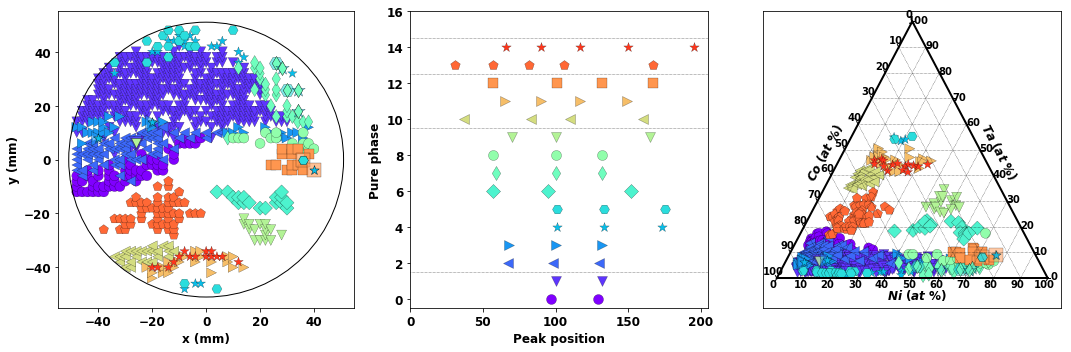


Finding pure phases, each cluster with min 13 points, peak sep at most 2
num peaks in the dataset: set([2, 3, 4, 5, 6, 7, 8, 9])
total pure rep:  14
[951, 753, 17, 3]
pure phases  (1724, 205) (14, 205) (14,) (1724, 205) (1724, 3)
(14, 205) [0 0 2 6 3 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
pp: 753 mp: 20 outliers: 951
(14, 205) [0 0 2 6 3 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
ax ternary: (1724, 205)
using existing axis
ternary..labels: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13] [4376   89  301  101   34   24   19   44   17   25   30   17   54   27   14]
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0

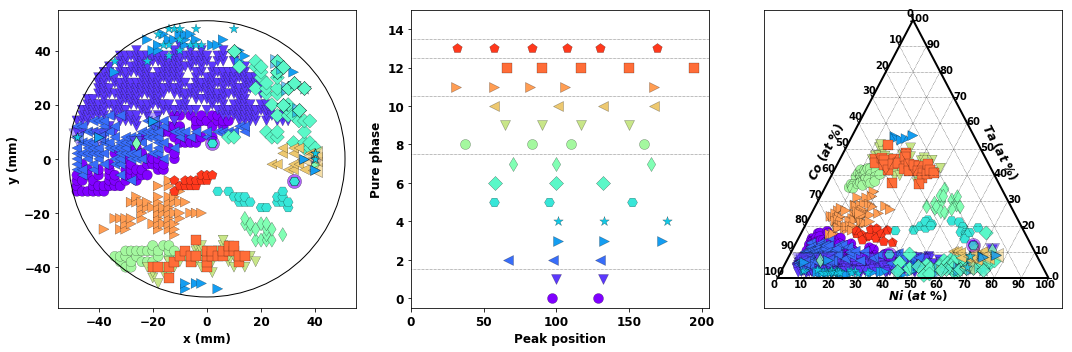


Finding pure phases, each cluster with min 14 points, peak sep at most 4
num peaks in the dataset: set([2, 3, 4, 5, 6, 7, 8, 9])
total pure rep:  13
[878, 809, 37, 0]
pure phases  (1724, 205) (13, 205) (13,) (1724, 205) (1724, 3)
(13, 205) [0 0 1 5 3 3 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 1
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
pp: 809 mp: 37 outliers: 878
(13, 205) [0 0 1 5 3 3 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 1
ax ternary: (1724, 205)
using existing axis
ternary..labels: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12] [4289  399  117   48   61   19   28   25   33   26   18   62   33   14]
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 39

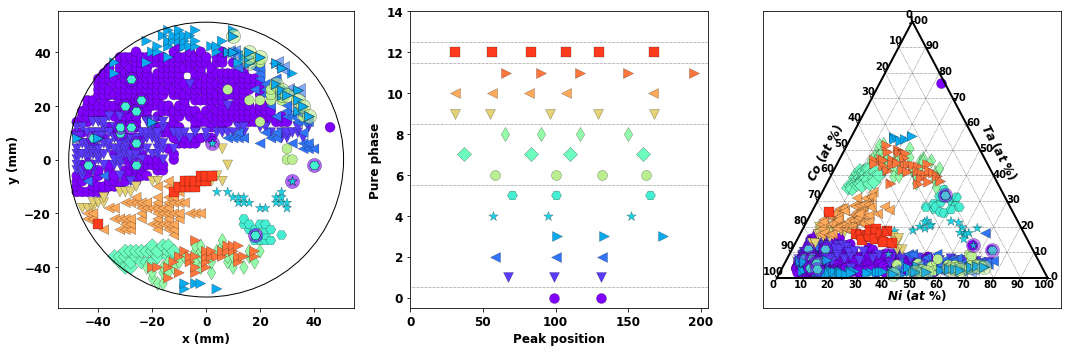


Finding pure phases, each cluster with min 12 points, peak sep at most 20
num peaks in the dataset: set([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])
total pure rep:  16
[1053, 446, 34, 0]
pure phases  (1533, 1455) (16, 1455) (16,) (1533, 1455) (1533, 3)
(16, 1455) [0 1 4 3 6 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 4
(1533, 1455) [  0 114 116 172 208 171 126 107  95  92  89  50  37  18  15  14   6   8
   6   5  19  30  27   7   1   0   0   0   0   0] 116
(1533, 1455) [  0 114 116 172 208 171 126 107  95  92  89  50  37  18  15  14   6   8
   6   5  19  30  27   7   1   0   0   0   0   0] 116
pp: 446 mp: 34 outliers: 1053
(16, 1455) [0 1 4 3 6 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 4
ax ternary: (1533, 1455)
using existing axis
ternary..labels: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] [4085  110   22   20   28   44   21   41   72   21   23   18   16   13   25
   28   12]
(1533, 1455) [  0 114 116 172 208 171 

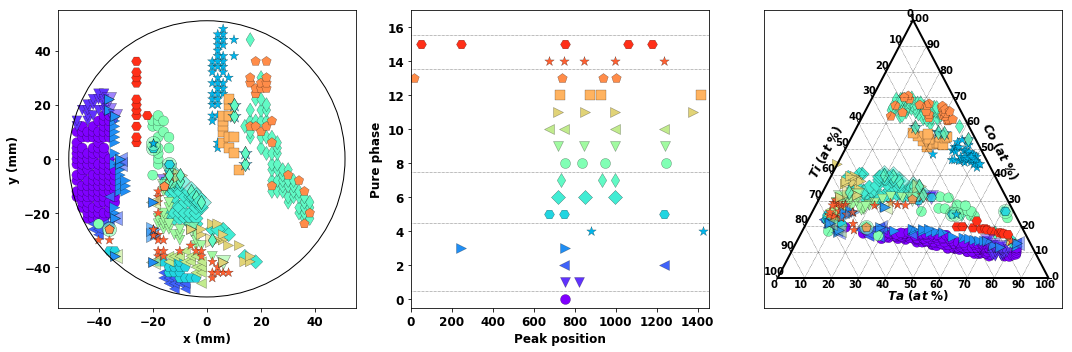

In [80]:
pure_count_dict = peak_algo_graphs([pts_200], thresh_equals=[1],
                                   thresh_outliers=[12], save_dir='Graphs/final2')
pure_count_dict = peak_algo_graphs([pts_200], thresh_equals=[2],
                                   thresh_outliers=[13], save_dir='Graphs/final2')
pure_count_dict = peak_algo_graphs([pts_200], thresh_equals=[4],
                                   thresh_outliers=[14], save_dir='Graphs/final2')
pure_count_dict = peak_algo_graphs([pts_1450], thresh_equals=[20],
                                   thresh_outliers=[12], save_dir='Graphs/final2')

In [81]:
pures, counters, all_data, members = fuzzy_find_pure(pts_200,
                                             thresh_equals=1,
                                             thresh_outliers=12)

num peaks in the dataset: set([2, 3, 4, 5, 6, 7, 8, 9])
total pure rep:  15




 data:200 metric name:diff_pos hc_meth:average hc_crit:distance hpc_param:100.0
Total number of clusters:  4
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
pp: 727 mp: 3 outliers: 994
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
ax ternary: (1724, 205)
using existing axis
ternary..labels: [-1  1  2  3  4] [4432  383  227   61   69]
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
saved to  Graphs/final2/th01-ot12-diff_pos-average-distance-10000000


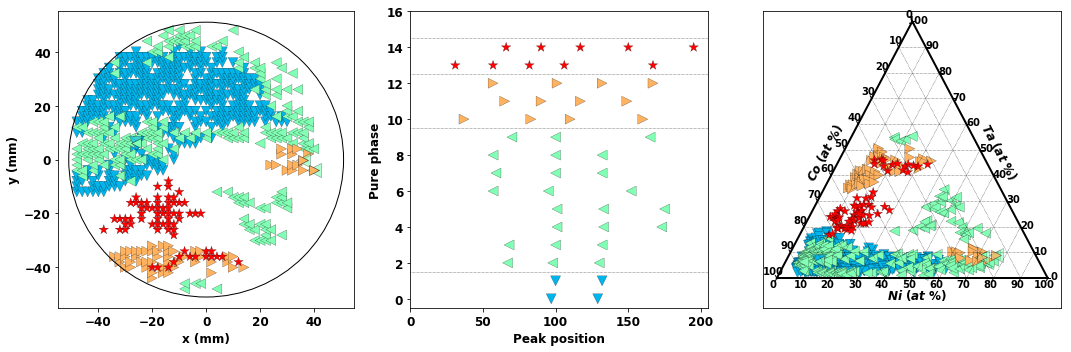



 data:200 metric name:diff_pos hc_meth:average hc_crit:distance hpc_param:50.0
Total number of clusters:  4
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
pp: 727 mp: 3 outliers: 994
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
ax ternary: (1724, 205)
using existing axis
ternary..labels: [-1  1  2  3  4] [4432  383  227   61   69]
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
saved to  Graphs/final2/th01-ot12-diff_pos-average-distance-5000000


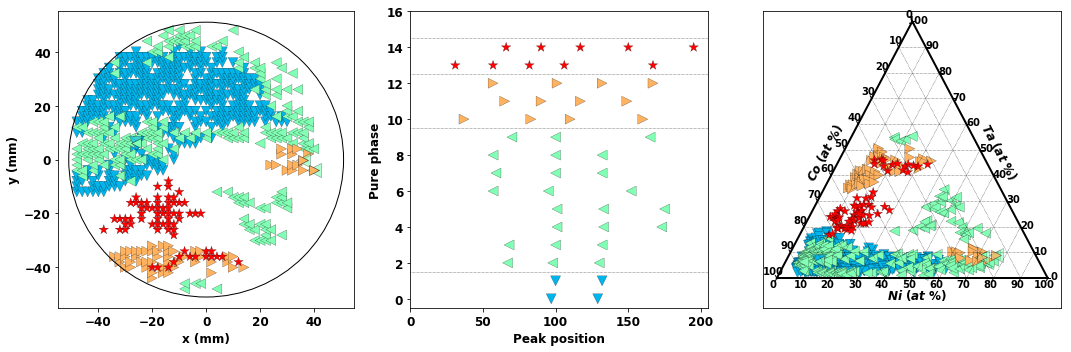



 data:200 metric name:diff_pos hc_meth:average hc_crit:distance hpc_param:25.0
Total number of clusters:  6
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
pp: 720 mp: 10 outliers: 994
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
ax ternary: (1724, 205)
using existing axis
ternary..labels: [-1  1  2  3  4  5  6] [4432  383   46  181   61   54   15]
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
saved to  Graphs/final2/th01-ot12-diff_pos-average-distance-2500000


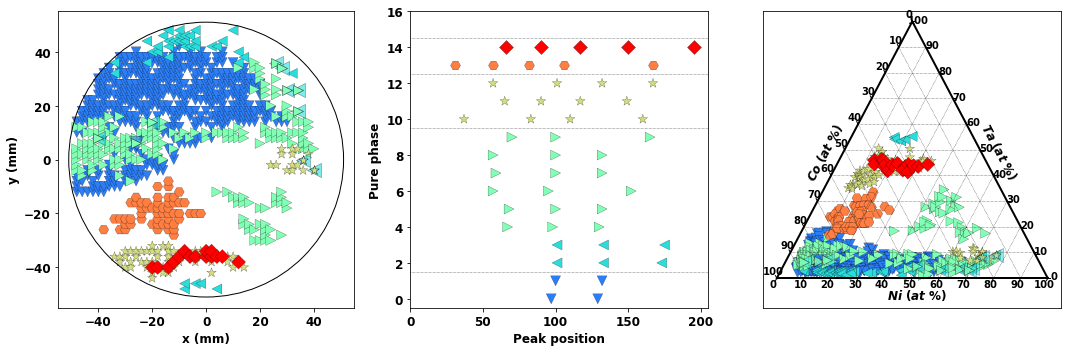



 data:200 metric name:diff_pos hc_meth:average hc_crit:distance hpc_param:12.5
Total number of clusters:  9
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
pp: 720 mp: 10 outliers: 994
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
ax ternary: (1724, 205)
using existing axis
ternary..labels: [-1  1  2  3  4  5  6  7  8  9] [4432  383   46  165   16   21   15   25   54   15]
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
saved to  Graphs/final2/th01-ot12-diff_pos-average-distance-1250000


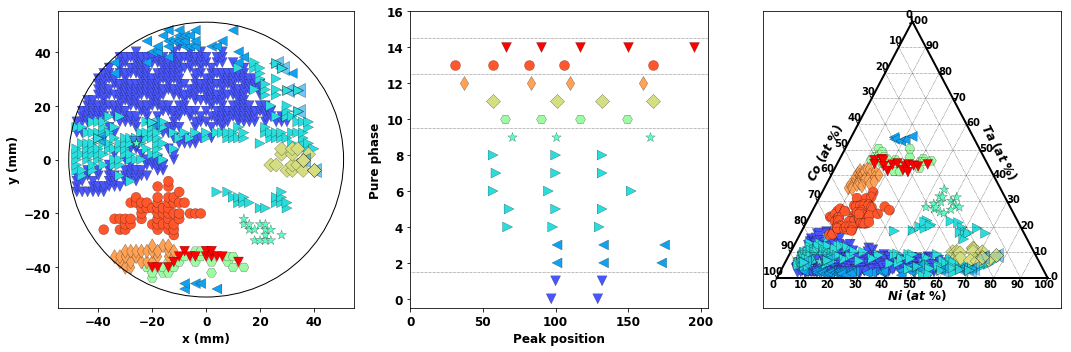



 data:200 metric name:diff_pos hc_meth:average hc_crit:distance hpc_param:6.25
Total number of clusters:  10
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
pp: 720 mp: 10 outliers: 994
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
ax ternary: (1724, 205)
using existing axis
ternary..labels: [-1  1  2  3  4  5  6  7  8  9 10] [4432  383   46  148   17   16   21   15   25   54   15]
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
saved to  Graphs/final2/th01-ot12-diff_pos-average-distance-625000


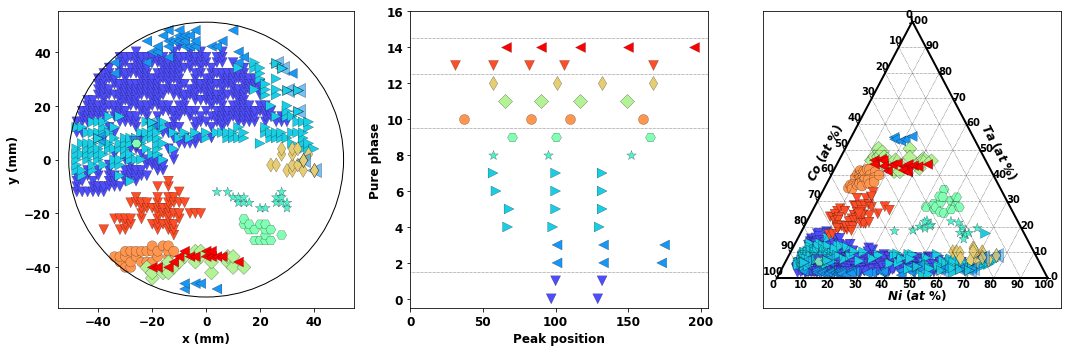



 data:200 metric name:diff_pos hc_meth:average hc_crit:distance hpc_param:3.125
Total number of clusters:  11
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
pp: 720 mp: 10 outliers: 994
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
ax ternary: (1724, 205)
using existing axis
ternary..labels: [-1  1  2  3  4  5  6  7  8  9 10 11] [4432  383   46   43  105   17   16   21   15   25   54   15]
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
saved to  Graphs/final2/th01-ot12-diff_pos-average-distance-312500


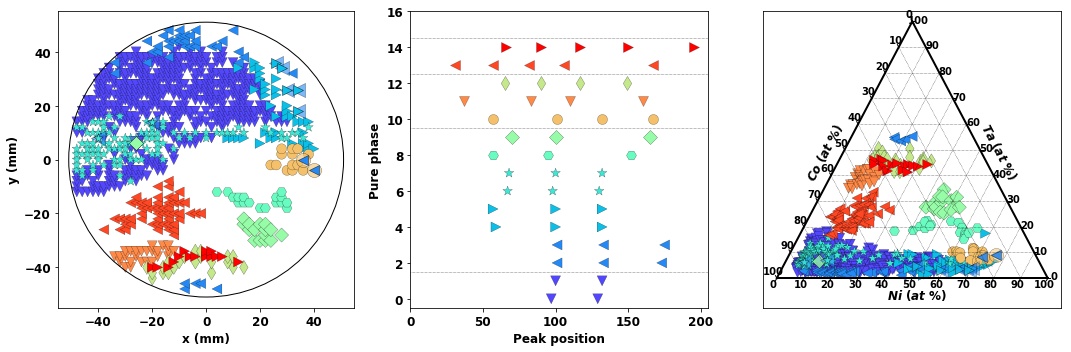



 data:200 metric name:diff_pos hc_meth:average hc_crit:distance hpc_param:1.5625
Total number of clusters:  13
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
pp: 720 mp: 10 outliers: 994
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
ax ternary: (1724, 205)
using existing axis
ternary..labels: [-1  1  2  3  4  5  6  7  8  9 10 11 12 13] [4432   60  323   46   43   72   33   17   16   21   15   25   54   15]
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
saved to  Graphs/final2/th01-ot12-diff_pos-average-distance-156250


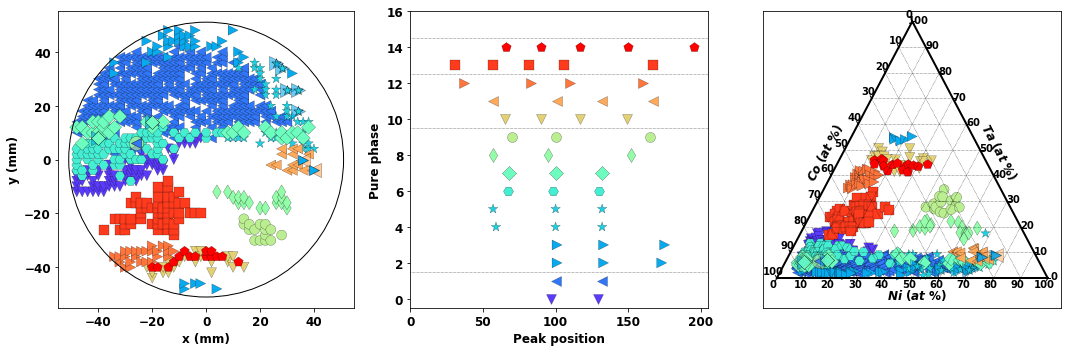



 data:200 metric name:diff_pos hc_meth:average hc_crit:distance hpc_param:0.78125
Total number of clusters:  13
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
pp: 720 mp: 10 outliers: 994
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
ax ternary: (1724, 205)
using existing axis
ternary..labels: [-1  1  2  3  4  5  6  7  8  9 10 11 12 13] [4432   60  323   46   43   72   33   17   16   21   15   25   54   15]
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
saved to  Graphs/final2/th01-ot12-diff_pos-average-distance-78125


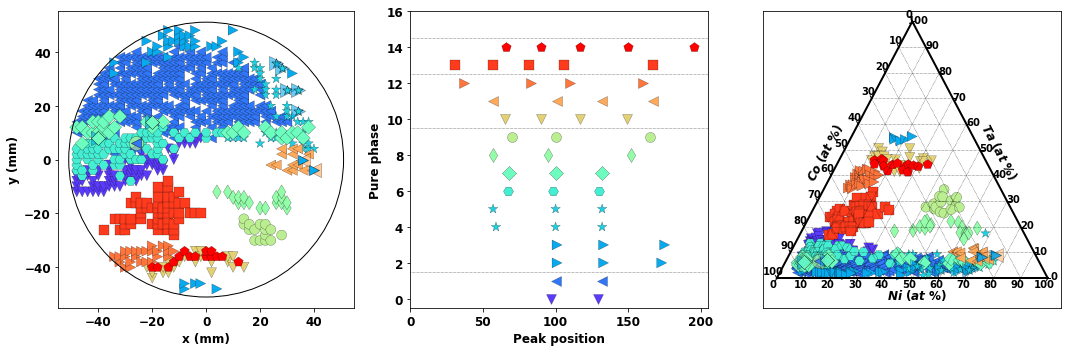



 data:200 metric name:diff_pos hc_meth:average hc_crit:distance hpc_param:0.390625
Total number of clusters:  15
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
pp: 720 mp: 10 outliers: 994
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
ax ternary: (1724, 205)
using existing axis
ternary..labels: [-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] [4432   60  323   26   20   28   15   72   33   17   16   21   15   25   54
   15]
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
saved to  Graphs/final2/th01-ot12-diff_pos-average-distance-39062


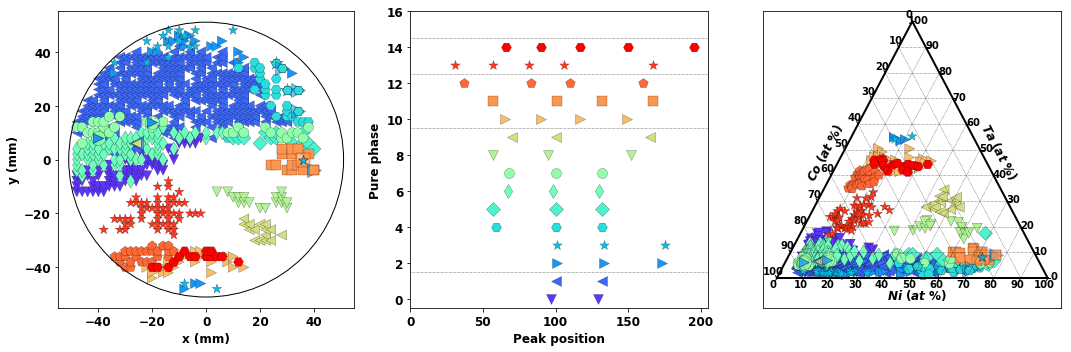



 data:200 metric name:diff_pos hc_meth:average hc_crit:distance hpc_param:0.1953125
Total number of clusters:  15
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
pp: 720 mp: 10 outliers: 994
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
ax ternary: (1724, 205)
using existing axis
ternary..labels: [-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] [4432   60  323   26   20   28   15   72   33   17   16   21   15   25   54
   15]
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
saved to  Graphs/final2/th01-ot12-diff_pos-average-distance-19531


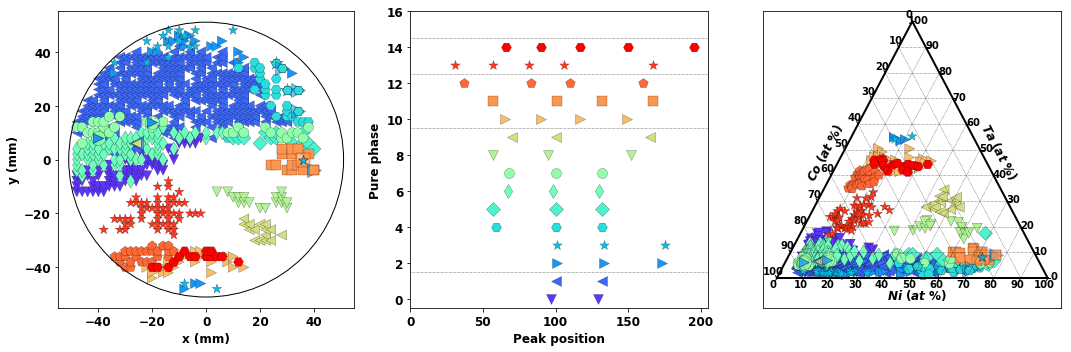



 data:200 metric name:diff_pos hc_meth:average hc_crit:distance hpc_param:0.09765625
Total number of clusters:  15
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
pp: 720 mp: 10 outliers: 994
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
ax ternary: (1724, 205)
using existing axis
ternary..labels: [-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] [4432   60  323   26   20   28   15   72   33   17   16   21   15   25   54
   15]
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
saved to  Graphs/final2/th01-ot12-diff_pos-average-distance-09765


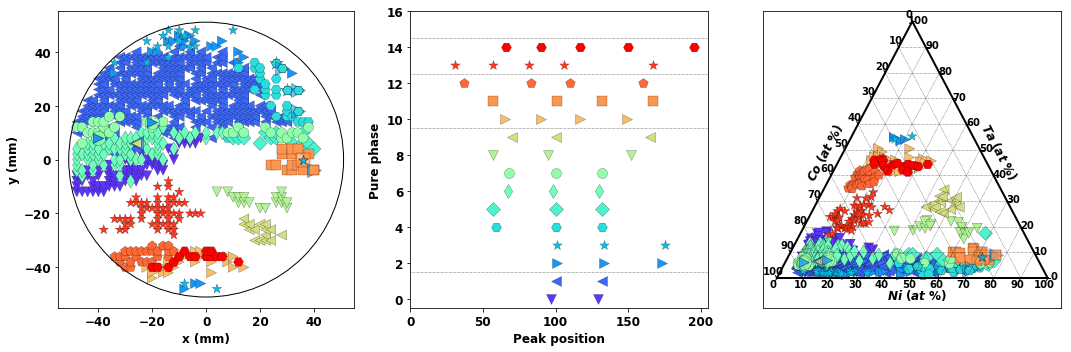



 data:200 metric name:diff_pos hc_meth:average hc_crit:distance hpc_param:0.048828125
Total number of clusters:  15
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
pp: 720 mp: 10 outliers: 994
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
ax ternary: (1724, 205)
using existing axis
ternary..labels: [-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] [4432   60  323   26   20   28   15   72   33   17   16   21   15   25   54
   15]
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
saved to  Graphs/final2/th01-ot12-diff_pos-average-distance-04882


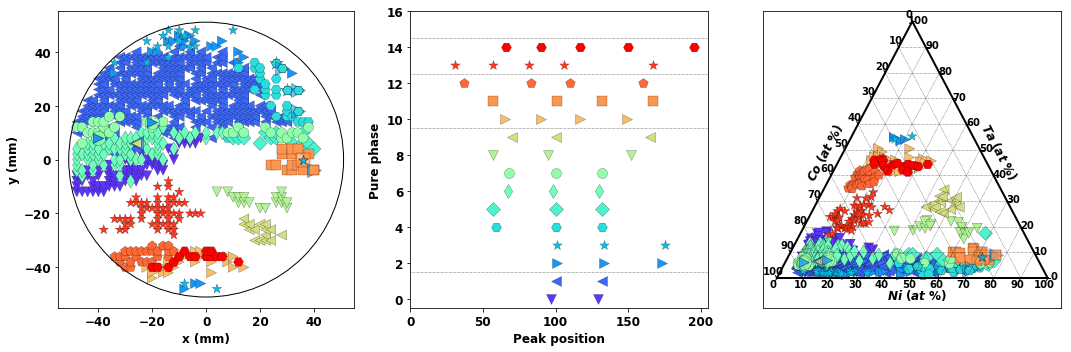



 data:200 metric name:diff_pos hc_meth:average hc_crit:distance hpc_param:0.0244140625
Total number of clusters:  15
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
pp: 720 mp: 10 outliers: 994
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
ax ternary: (1724, 205)
using existing axis
ternary..labels: [-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] [4432   60  323   26   20   28   15   72   33   17   16   21   15   25   54
   15]
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
saved to  Graphs/final2/th01-ot12-diff_pos-average-distance-02441


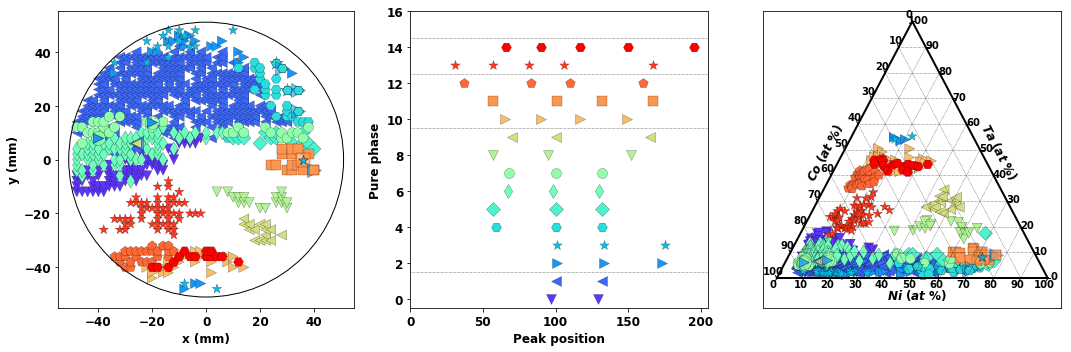



 data:200 metric name:diff_pos hc_meth:average hc_crit:distance hpc_param:0.01220703125
Total number of clusters:  15
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
pp: 720 mp: 10 outliers: 994
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
ax ternary: (1724, 205)
using existing axis
ternary..labels: [-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] [4432   60  323   26   20   28   15   72   33   17   16   21   15   25   54
   15]
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
saved to  Graphs/final2/th01-ot12-diff_pos-average-distance-01220


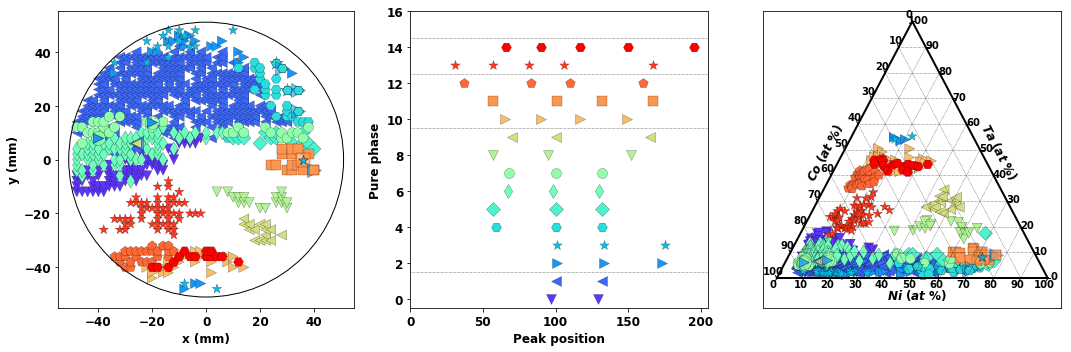



 data:200 metric name:diff_pos hc_meth:average hc_crit:distance hpc_param:0.006103515625
Total number of clusters:  15
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
pp: 720 mp: 10 outliers: 994
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
ax ternary: (1724, 205)
using existing axis
ternary..labels: [-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] [4432   60  323   26   20   28   15   72   33   17   16   21   15   25   54
   15]
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
saved to  Graphs/final2/th01-ot12-diff_pos-average-distance-00610


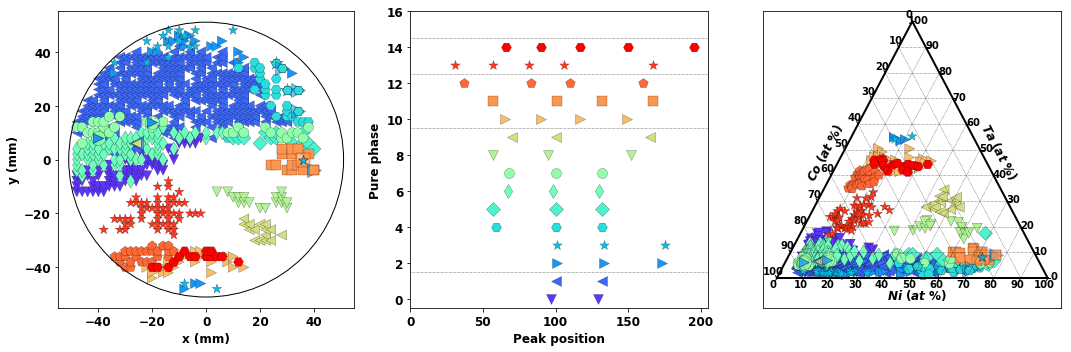



 data:200 metric name:diff_pos hc_meth:average hc_crit:distance hpc_param:0.0030517578125
Total number of clusters:  15
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
pp: 720 mp: 10 outliers: 994
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
ax ternary: (1724, 205)
using existing axis
ternary..labels: [-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] [4432   60  323   26   20   28   15   72   33   17   16   21   15   25   54
   15]
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
saved to  Graphs/final2/th01-ot12-diff_pos-average-distance-00305


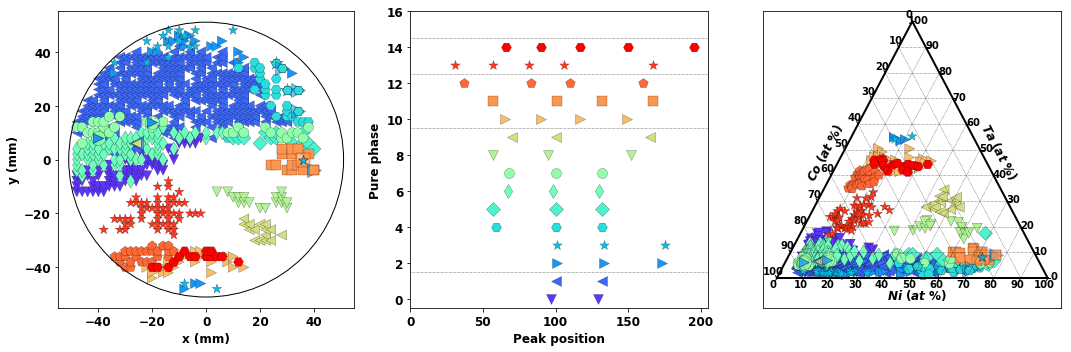



 data:200 metric name:diff_pos hc_meth:average hc_crit:distance hpc_param:0.00152587890625
Total number of clusters:  15
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
pp: 720 mp: 10 outliers: 994
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
ax ternary: (1724, 205)
using existing axis
ternary..labels: [-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] [4432   60  323   26   20   28   15   72   33   17   16   21   15   25   54
   15]
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
saved to  Graphs/final2/th01-ot12-diff_pos-average-distance-00152


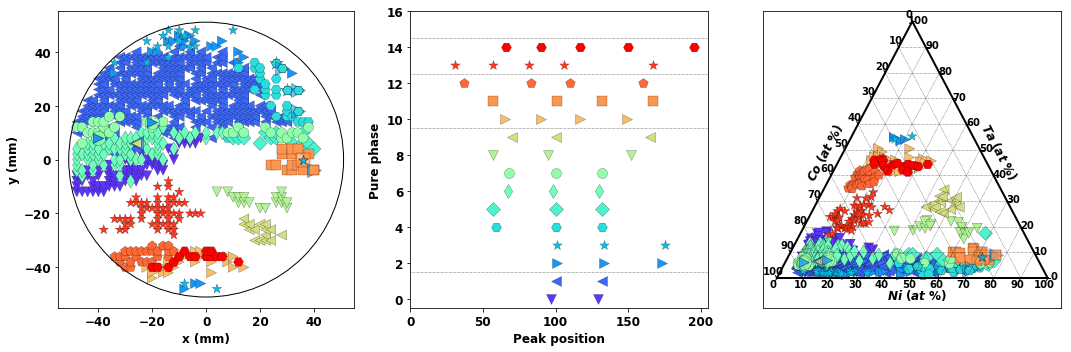



 data:200 metric name:diff_pos hc_meth:average hc_crit:distance hpc_param:0.000762939453125
Total number of clusters:  15
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
pp: 720 mp: 10 outliers: 994
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
ax ternary: (1724, 205)
using existing axis
ternary..labels: [-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] [4432   60  323   26   20   28   15   72   33   17   16   21   15   25   54
   15]
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
saved to  Graphs/final2/th01-ot12-diff_pos-average-distance-00076


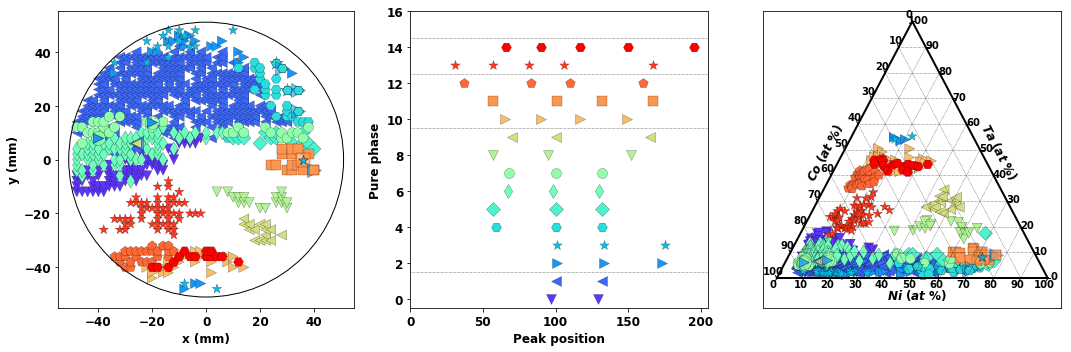



 data:200 metric name:diff_pos hc_meth:average hc_crit:distance hpc_param:0.000381469726562
Total number of clusters:  15
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
pp: 720 mp: 10 outliers: 994
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
ax ternary: (1724, 205)
using existing axis
ternary..labels: [-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] [4432   60  323   26   20   28   15   72   33   17   16   21   15   25   54
   15]
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
saved to  Graphs/final2/th01-ot12-diff_pos-average-distance-00038


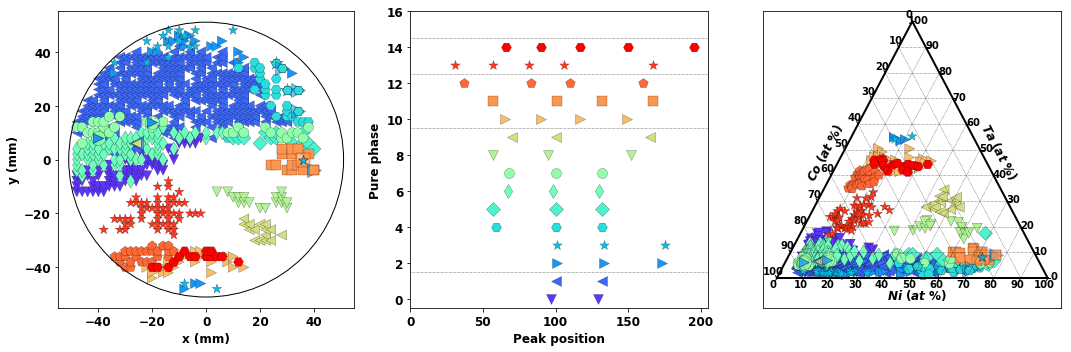



 data:200 metric name:diff_pos hc_meth:average hc_crit:distance hpc_param:0.000190734863281
Total number of clusters:  15
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
pp: 720 mp: 10 outliers: 994
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
ax ternary: (1724, 205)
using existing axis
ternary..labels: [-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] [4432   60  323   26   20   28   15   72   33   17   16   21   15   25   54
   15]
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
saved to  Graphs/final2/th01-ot12-diff_pos-average-distance-00019


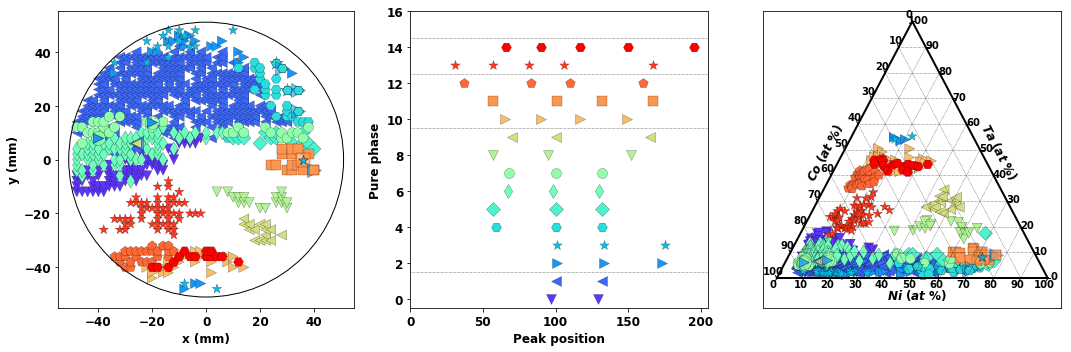



 data:200 metric name:diff_pos hc_meth:average hc_crit:distance hpc_param:9.53674316406e-05
Total number of clusters:  15
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
pp: 720 mp: 10 outliers: 994
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
ax ternary: (1724, 205)
using existing axis
ternary..labels: [-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] [4432   60  323   26   20   28   15   72   33   17   16   21   15   25   54
   15]
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
saved to  Graphs/final2/th01-ot12-diff_pos-average-distance-00009


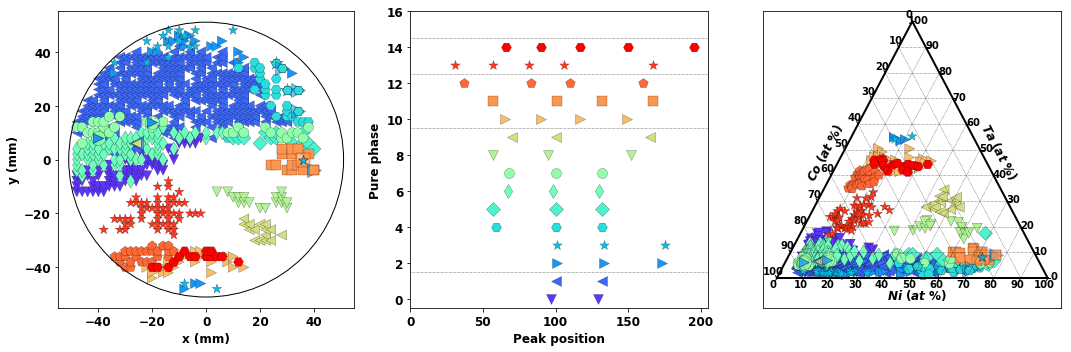



 data:200 metric name:diff_pos hc_meth:average hc_crit:distance hpc_param:4.76837158203e-05
Total number of clusters:  15
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
pp: 720 mp: 10 outliers: 994
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
ax ternary: (1724, 205)
using existing axis
ternary..labels: [-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] [4432   60  323   26   20   28   15   72   33   17   16   21   15   25   54
   15]
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
saved to  Graphs/final2/th01-ot12-diff_pos-average-distance-00004


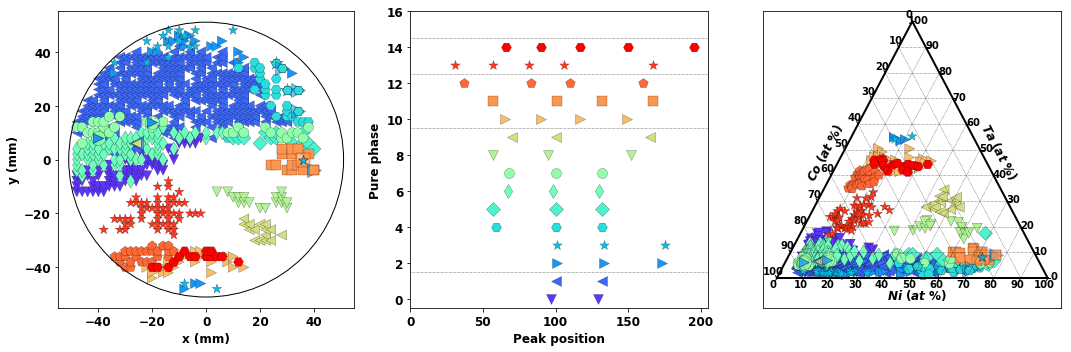



 data:200 metric name:diff_pos hc_meth:average hc_crit:distance hpc_param:2.38418579102e-05
Total number of clusters:  15
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
pp: 720 mp: 10 outliers: 994
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
ax ternary: (1724, 205)
using existing axis
ternary..labels: [-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] [4432   60  323   26   20   28   15   72   33   17   16   21   15   25   54
   15]
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
saved to  Graphs/final2/th01-ot12-diff_pos-average-distance-00002


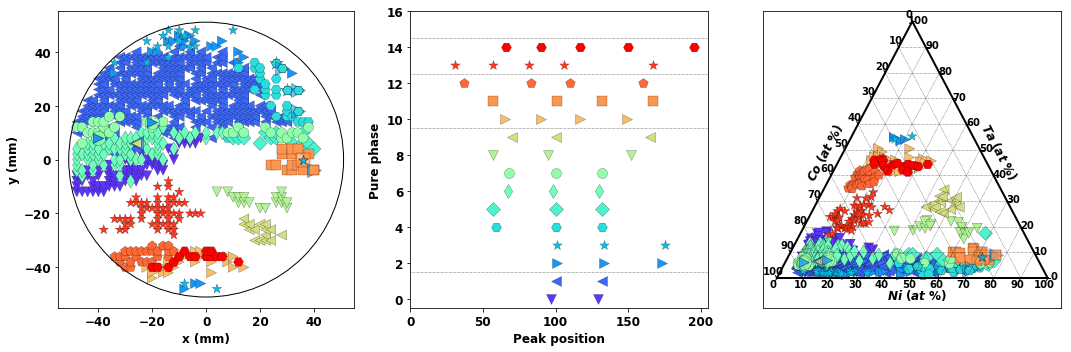



 data:200 metric name:diff_pos hc_meth:average hc_crit:distance hpc_param:1.19209289551e-05
Total number of clusters:  15
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
pp: 720 mp: 10 outliers: 994
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
ax ternary: (1724, 205)
using existing axis
ternary..labels: [-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] [4432   60  323   26   20   28   15   72   33   17   16   21   15   25   54
   15]
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
saved to  Graphs/final2/th01-ot12-diff_pos-average-distance-00001


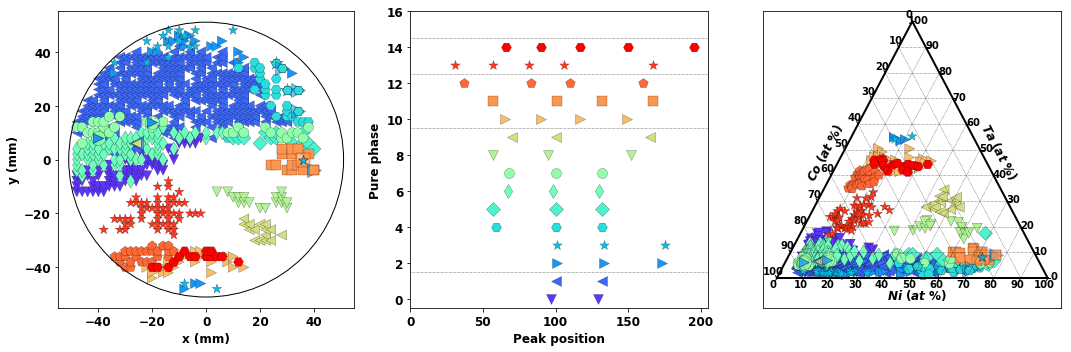



 data:200 metric name:diff_pos hc_meth:average hc_crit:distance hpc_param:5.96046447754e-06
Total number of clusters:  15
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
pp: 720 mp: 10 outliers: 994
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
ax ternary: (1724, 205)
using existing axis
ternary..labels: [-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] [4432   60  323   26   20   28   15   72   33   17   16   21   15   25   54
   15]
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
saved to  Graphs/final2/th01-ot12-diff_pos-average-distance-00000


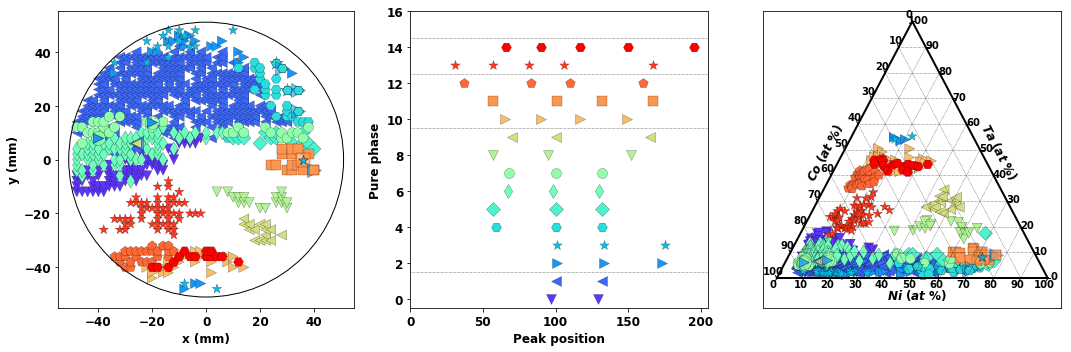



 data:200 metric name:diff_pos hc_meth:average hc_crit:distance hpc_param:2.98023223877e-06
Total number of clusters:  15
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
pp: 720 mp: 10 outliers: 994
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
ax ternary: (1724, 205)
using existing axis
ternary..labels: [-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] [4432   60  323   26   20   28   15   72   33   17   16   21   15   25   54
   15]
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
saved to  Graphs/final2/th01-ot12-diff_pos-average-distance-00000


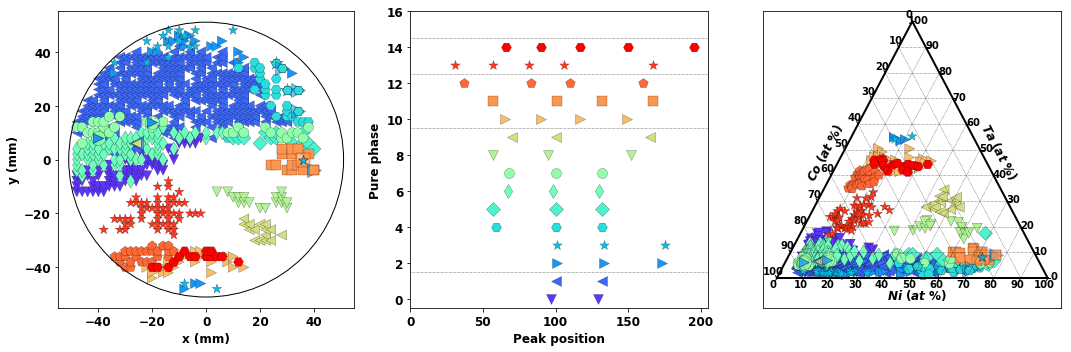



 data:200 metric name:diff_pos hc_meth:average hc_crit:distance hpc_param:1.49011611938e-06
Total number of clusters:  15
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
pp: 720 mp: 10 outliers: 994
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
ax ternary: (1724, 205)
using existing axis
ternary..labels: [-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] [4432   60  323   26   20   28   15   72   33   17   16   21   15   25   54
   15]
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
saved to  Graphs/final2/th01-ot12-diff_pos-average-distance-00000


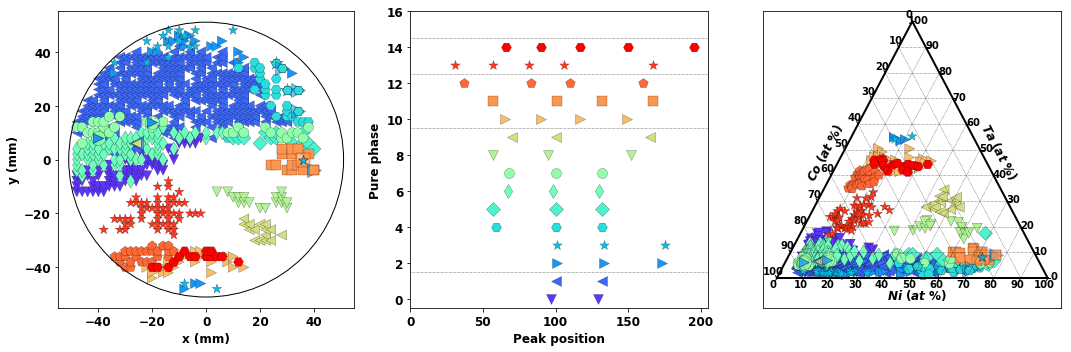



 data:200 metric name:diff_pos hc_meth:average hc_crit:distance hpc_param:7.45058059692e-07
Total number of clusters:  15
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
pp: 720 mp: 10 outliers: 994
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
ax ternary: (1724, 205)
using existing axis
ternary..labels: [-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] [4432   60  323   26   20   28   15   72   33   17   16   21   15   25   54
   15]
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
saved to  Graphs/final2/th01-ot12-diff_pos-average-distance-00000


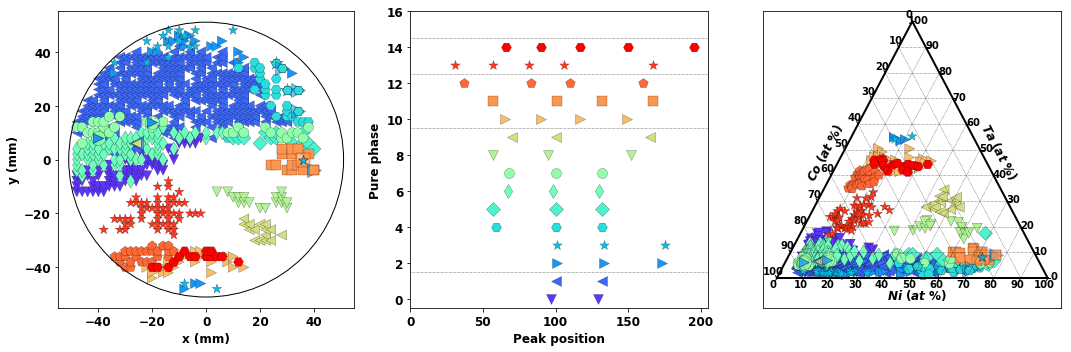



 data:200 metric name:diff_pos hc_meth:average hc_crit:distance hpc_param:3.72529029846e-07
Total number of clusters:  15
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
pp: 720 mp: 10 outliers: 994
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
ax ternary: (1724, 205)
using existing axis
ternary..labels: [-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] [4432   60  323   26   20   28   15   72   33   17   16   21   15   25   54
   15]
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
saved to  Graphs/final2/th01-ot12-diff_pos-average-distance-00000


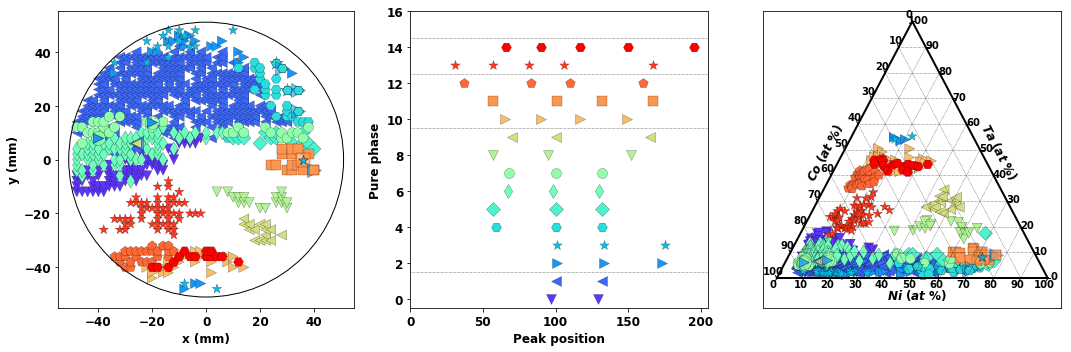



 data:200 metric name:diff_pos hc_meth:average hc_crit:distance hpc_param:1.86264514923e-07
Total number of clusters:  15
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
pp: 720 mp: 10 outliers: 994
(15, 205) [0 0 2 8 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
ax ternary: (1724, 205)
using existing axis
ternary..labels: [-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] [4432   60  323   26   20   28   15   72   33   17   16   21   15   25   54
   15]
(1724, 205) [  0   0 398 275 259 247 198 249  87  11   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] 398
saved to  Graphs/final2/th01-ot12-diff_pos-average-distance-00000


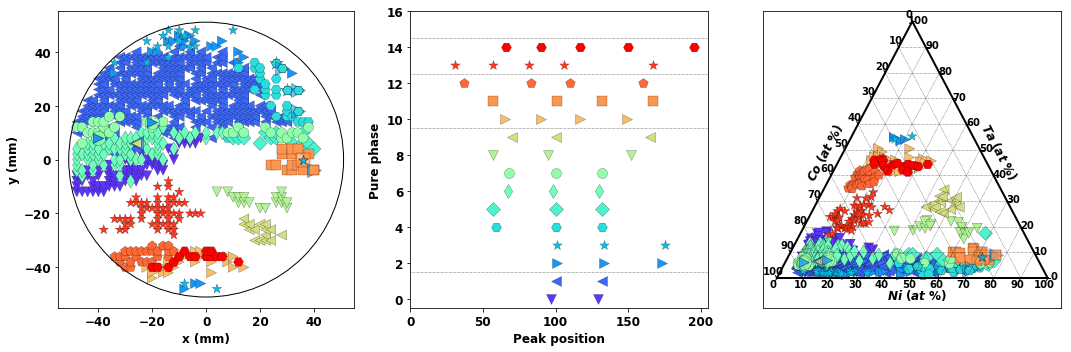

done for diff_pos: 
done for dataset 200:


In [82]:
hc_dist_metrics=[dist_helper, use_emd, diff_pos, diff_max, diff_sum, diff_prod, diff_shift,
                'euclidean', 'cosine', 'seuclidean', 'correlation', 'hamming', 'jaccard', 
                      'chebyshev', 'canberra', 'braycurtis', 'mahalanobis', 'dice', 'kulsinski', 'rogerstanimoto',
                     'russellrao', 'sokalmichener'][2:3]
hc_dist_metric_names=['fuzzy', 'use_emd','diff_pos', 'diff_max','diff_sum', 'diff_prod', 'diff_shift', 
                      'euclidean', 'cosine', 'seuclidean', 'correlation', 'hamming', 'jaccard', 
                      'chebyshev', 'canberra', 'braycurtis', 'mahalanobis', 'dice', 'kulsinski', 'rogerstanimoto',
                     'russellrao', 'sokalmichener'][2:3]
hc_methods = ['average', 'centroid', 'ward'][:1]
hc_criteria = ['distance']
#hc_params=[10/(2.**fact), 10/(10.**fact), 10/(2.**fact), 10/(2.**fact), 10/(2.**fact), 10/(2.**fact)][:3]) 

rep = 30
datastr = ['200']
for p, pts in enumerate([pts_200]):
    for metric, metric_name in zip(hc_dist_metrics, hc_dist_metric_names):
        st = 100.
        if metric_name=='use_emd': ft = 10.
        else: ft=2.
        hc_params = [st/(ft**x) for x in range(rep)]
        for hc_meth in hc_methods:
            for hc_crit in hc_criteria:
                for hc_param in hc_params:
                    for ua in [True, False][1:]:
                        uas = 'T' if ua else 'F'
                        print '\n\n data:%s metric name:%s hc_meth:%s hc_crit:%s hpc_param:%s'%(datastr[p], metric_name, hc_meth, hc_crit, hc_param)
                        new_pures_, pure_labels_, new_counters_, new_members_, peak_clust = hcluster_potentials(pures, members, counters, 
                    param=hc_param, hc_meth = hc_meth, hc_criterion=hc_crit,dist_metric=metric, use_all=ua)
                        dynamic_plot(pures, [pure_labels_], all_data, [new_members_], fig_name='th01-ot12-%s-%s-%s-%05d'%(metric_name, hc_meth, hc_crit, int(hc_param*100000)), pure_only=False,
                             save_dir='Graphs/final2')
                        #except: continue
        print 'done for %s: '%metric_name
    print 'done for dataset %s:'%datastr[p]

In [83]:
# #we need three clusters for 2 peak points, but these values gives either 1 or 2
# cluster_plot([pts_200], thresh_equals=[2,2], 
#              thresh_outliers=[5,10], 
#              hc_dist_metrics=[dist_helper, diff_pos, use_emd], 
#              hc_dist_metric_names=['fuzzy', 'diff_pos', 'use_emd'], 
#              hc_params=[1, 1, 1e-10])

In [84]:
# hc_dist_metrics=[dist_helper, use_emd, diff_pos, diff_max, diff_sum, diff_prod, diff_shift,
#                 'euclidean', 'cosine', 'seuclidean', 'correlation', 'hamming', 'jaccard', 
#                       'chebyshev', 'canberra', 'braycurtis', 'mahalanobis', 'dice', 'kulsinski', 'rogerstanimoto',
#                      'russellrao', 'sokalmichener']
# hc_dist_metric_names=['fuzzy', 'use_emd','diff_pos', 'diff_max','diff_sum', 'diff_prod', 'diff_shift', 
#                       'euclidean', 'cosine', 'seuclidean', 'correlation', 'hamming', 'jaccard', 
#                       'chebyshev', 'canberra', 'braycurtis', 'mahalanobis', 'dice', 'kulsinski', 'rogerstanimoto',
#                      'russellrao', 'sokalmichener']

# hc_methods = ['average', 'centroid', 'ward']
# hc_criteria = ['distance']
# #hc_params=[10/(2.**fact), 10/(10.**fact), 10/(2.**fact), 10/(2.**fact), 10/(2.**fact), 10/(2.**fact)][:3]) 


# rep = 30
# datastr = ['points1_200', 'points2_200']
# for p, pts in enumerate([pts_200, pts2_200]):
#     for metric, metric_name in zip(hc_dist_metrics, hc_dist_metric_names):
#         st = 100.
#         if metric_name=='use_emd': ft = 10.
#         else: ft=2.
#         hc_params = [st/(ft**x) for x in range(rep)]
#         for hc_meth in hc_methods:
#             for hc_crit in hc_criteria:
#                 try:
#                     print '\n\n data:%s metric name:%s hc_meth:%s hc_crit:%s'%(datastr[p], metric_name, hc_meth, hc_crit)
#                     cluster_plot_metric([pts_200], thresh_equals=[2,5],
#                       thresh_outliers=[5,10,15],
#                       hc_dist_metrics=[metric]*rep,
#                       hc_dist_metric_names=[metric_name]*rep,
#                       hc_criterion = hc_crit, hc_meth = hc_meth,
#                       hc_params=hc_params, save_dir='Graphs/%s/run14/%s'%(datastr[p], metric_name))
#                 except: continue
#         print 'done for %s: '%metric_name
#     print 'done for dataset %s:'%datastr[p]